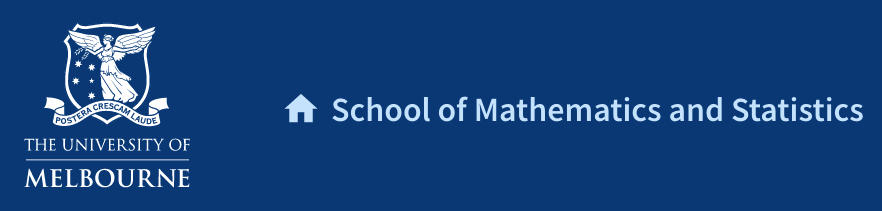

In [1]:
# Imports from helper files
# These will make code run if you would like to, 
# but all report results were actually attained in other notebooks
# see "Simulated Annealing.ipynb" and "Stages 0-2.ipynb"

from metro_utils import (graph, extract_stations, pairs2rails, subsets, 
                         total_distance, gen_distance_matrix, graph_x)
from station import Station
from city import City

from collections import defaultdict as dd
import numpy as np

import gurobipy as gp
from gurobipy import GRB


# Load example test case for this notebook
from json import load

ignore_fields = ["description", "comment", "source"]
def filter_ignore(d):
    return {k: v for k, v in d.items() if k not in ignore_fields}

with open("test_cases.json", "r") as f:
    tests = load(f, object_hook=filter_ignore)
    
# Choose problem to use in code below
test_choice = "dispersed"
locations = tests[test_choice]["locations"]
kinds = tests[test_choice]["kinds"]

city = City(**tests[test_choice])
stations = city.stations

# MAST 90014 - Group Project





## Group members:

Member 1 - Callum Holmes

Member 2 - Cameron Chandler

Member 3 - Isobel Abell

Member 4 - James Nelson

Member 5 - Mingjian Yin

Member 6 - Wenlin Zhang

# Project report

## Table of Contents

1. Introduction
2. Problem Definition
3. Data
4. Stage 0 - TSP
5. Stage 1 - Ants
6. Stage 2 - SDVRP
7. Stage 3 - Simulated Annealing
8. Validation and Analysis
9. Conclusion



## 1. Introduction 

Mini Metro is a 2014 minimalist puzzle game developed by Dinosaur Polo Club (2014) that tasks players with designing efficient subway systems. In each level the player visits various cities from across the world to design an efficient railway system according to the landscape presented to them. Once the game starts, stations of different shapes (circles, squares, triangles etc.) will start appearing. Passengers appear gradually at each station, represented by shapes that indicate the type of the station they want to travel to. The player must design a rail network to efficiently transport all passengers to their destinations on time using a constrained number of trains and lines. As the game progresses, levels becoming increasingly difficult with more stations and more passengers to transport around the city. As levels become more complex, players can unlock additional resources such as trains, lines, carriages and tunnels. The game ends when too many passengers have been waiting too long at any give station. Our objective is therefore to carry as many passengers as possible to their destinations before the game ends. 


Mini metro represents a realistic scheduling challenge. The different station shapes represent the different functions a station may have. For example, we could regard circles as residential areas, triangles as shopping centers and squares as downtown. Furthermore, many realistic railway optimisation problems prioritise access to the railway network which we can think of as maximising the number of people who reach their destination (Walker, 2014).


On the other hand, Mini Metro applies many simplifications compared to actual rail engineering. In particular, it allows the player to completely redesign the rail systems without any additional costs. From this perspective, this game shares more similarity with a transit network problem. Therefore, in our project, we also follow this perspective and build up a more comprehensive model that designs an optimal transit network in a more realistic setting.


We tackle our problem by considering four different model stages for the Mini Metro problem. After starting with an oversimplified Stage 0 model, the complexity of the model is progressively increased in order for the model to more and more closely resemble the Mini Metro problem. At stage 0, we aim at creating a simple loop that connects all the stations using the shortest distance. At stage 1, we add more flexibility by allowing more than one loop in the network while still treating the stations as homogeneous. At stage 2, we improve the flexibility by allowing either looped or non-looped rails, that are free to crossover with other tracks, and furthermore require the network to be fully-connected. To incorporate heterogeneous stations, in stage 3 we apply simulated annealing (a metaheuristic approach) to stochastically search for more practically applicable network designs.

While simple enough for a human to play, there are many features that makes Mini Metro difficult to model. By defining increasingly complex models at each of our stages, we explore both the ways in which the models define effective solutions and the limitations that appear at each step.


## 2. Problem definition





<!-- Formally define the problem. Which kind of simplifications are made? Which kind of problem variants do you wish to tackle?   -->
We firstly make some simplifications to the Mini Metro gameplay that are incorporated into all model stages. This was done to ensure the modelling is feasible for all stages of our analysis.

###Simplifications
####**Temporality and Stochasticity**
Throughout a level in the Mini Metro game, both new stations and new passengers will appear over time, meaning for optimal scores, players must plan for the future. To help accommodate an influx of passengers, players are given the choice of upgrades such as extra tunnels or trains or an interchange that can hold a certain number of people. In our analysis, we will take a snapshot of a level, optimising the route for the passengers and stations at a given point in time. The models won't consider the possibility of more stations or people being added, and we disregard any upgrades. 

####**Stations**
As a level progresses, players will gain access to special buildings called interchanges. These buildings can be placed on any station at any time and allow the associated station to a) hold 18 passengers before being overcrowded and b) drastically reduce passenger transfer time. In our models, we assume the stations to be homogeneous. That is, we do not differentiate the stations by their shapes and treat each station the same. 


<!-- ####Player Choice
As a player progresses through a level, they will be prompted to choose between various upgrades. This could be an extra tunnel or an extra train, or an extra carriage vs an interchange etc. The associated decision making at this points is of course not at all considered in this work.  -->



####**Trains**
In Mini Metro, the player can choose to place multiple trains on a single line, and can manually pick up and move trains elsewhere part way through a journey. While these elements are crucial for optimal gameplay, we do not consider them in our modelling. We assume that there is only one train on our route and it travels between all stations. As such, we do not need to explicitly consider trains, but instead model the length of track between stations which determines the travel time for passengers. Furthermore, we disregard train capacity assuming that all passengers at a given station will fit on the train. 

<!-- 
####Trains
% Trains are not modelled. In the game the player can choose to place multiple trains on a single line, and can even choose to move trains manually halfway through a journey. Such strategies make it difficult to model the time taken for passengers to travel so trains are excluded entirely. The exact placement of trains on a line (both location and direction) is another important decision for truly optimal play, but the difficulty of modelling such decisions and the associated diminishing returns from the effort are reasons for the exclusion of this also. This would be further complicated by the possibility of lines that are loops, and in this case the trains could either travel clockwise or anti-clockwise but would never turn around.

% Extra carriages can also be acquired to double the capacity of any given train. This additional complexity is also excluded. -->

####**Rails**
<!-- Some maps include rivers that require tunnels to traverse. Like lines, a fixed number of tunnels can be used at any time with no cost to move them. -->

<!-- In the game there is nuance with the angle of an ingoing and outgoing lines. If the angle is too sharp, the train will need to slow down even if it is not stopping. If the angle is shallow then the train can continue past at full speed. To simplify the problem, the acceleration of each train is not taken into account, and instead the distance between two stations is taken as a proxy for time. -->



We can calculate the distance between two stations using this diagram. Note that rails can only travel along four axes: the horizontal and vertical axes, and a 45 degree rotation from these. As evident from the diagram, the edge distance between two connected stations is:
$d(a, b) = \max(|a_x - b_x|, |a_y - b_y|) + (\sqrt{2} - 1)\min(|a_x - b_x|, |a_y - b_y|)$




**Figure 1**: Geometric lengths involved in rail connections

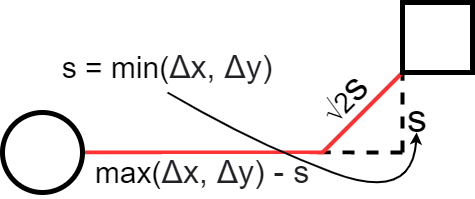


####**Passengers**
Passengers are an integral part of Mini Metro, however here we simplify their behaviour to suit our models. At each station, there can be a variable number of passengers who need to be delivered to different types of stations. The distribution of passengers across stations will of course have large impacts on the optimal rail placement. In addition, each passenger has an associated transfer time i.e. the time it takes them to get on or off the train. This transfer time means that full trains will take longer to deliver passengers than almost empty trains. We disregard this transfer time in our modelling. Since this time is so small, it is unlikely that this simplification will have a large impact on the optimal solution.



####**Game Objective**
As mentioned above, a point is scored in the Mini Metro game for every passenger delivered to their destination. There are no points associated with doing this efficiently. However, the game ends if any given station is overcrowded for too long. Specifically, overcrowding occurs when more than six passengers are waiting at a station, and the game ends if any station is overcrowded for 47 consecutive seconds. The true objective is merely to deliver passengers and doing so efficiently is simply a means to an end. If passengers are not delivered efficiently, then overcrowding is likely to occur and the game could end, preventing more points from being attained. Efficient delivery is feasible to model, while configuring the train network to deliver an optimal number of passengers would be difficult to define for a given frozen frame of gameplay. 

<!-- Therefore, in conclusion, we keep the stations homogeneous and specify  -->

<!-- 

#### **Stage 1**
inclusions from stage 0: multiple trains, with multiple depots \
getting little bit closer to minimetro, but not quite there

How we formulate\
We extend our formulation in Stage 0 to include multiple trains departing from multiple "depots". This problem type is known as the Multi-depot Multiple Travelling Salesman Problem (MmTSP). In this problem, every customer is visited once by one of the salesmen, who each depart from differing depots. While this is not required generally, we assume that each salesman must also return to their depot (this is called the fixed destination MmTSP). This applies directly to our Mini Metro problem as we think about the salesmen as trains and the customers as people. Each train departs from their own depot, picks up passengers (with no two trains picking up the same passenger) and returns to their depot. In this formulation, like with a single travelling salesman, each "customer" is visted once along the route with the goal being to minimise the total distance travelled on the tours. 

**Limitations**
As with Stage 0, we are still including simplifications in our mini-metro formulation, and so there are limitations in how we model our solutions. These limitations include: 
1.	Predetermined depots: instead of letting the algorithm choose the best starting points for the trains, we predetermine the depots for the trains, which can result in a local optimal solution rather than the global optimal solution in the setup of minimizing the overall distance given a fixed number of trains each forming a loop.
2.	A loop: it is not necessary for the train to travel in a loop in a more realistic setting. It can go back and forth alone a line.
3.	Homogenous station: at this stage we have not yet differentiated the stations. We are just designing how to draw smallest circles but have not considered if each station can have different function (i.e. different shapes in mini metro) and if each route can satisfy its passengers’ need to travel to stations with different functions
4.	No overlap in routes: in reality, we can have transfer stations that connect different routes, but not here.


#### **Stage 2**

**TODO**: Discuss Ant Colony formulation.

**TODO**: Discuss which model was better, motivating arguments here for which was finally chosen.

Our Stage 2 formulation sought to provide a MIP formulation addressing the three primary limitations of the MMTSP: the requirement to specify depots, the impossibility for any rail cross-overs or shared stations, and the prevention of loop rail paths. In particular, two different models were considered at this stage: an adaptation of the Split-Delivery Vehicle Routing Problem (SDVRP) formulation introduced in **Dror et al. (1990)**, and an "Ant Colony Algorithm" designed for solving MmTSP problems introduced in **Ghafurian et al. (2011)**.

The SDVRP model is an extension of the classic Vehicle Routing Problem (VRP). The VRP model works with $M$ homogenous vehicles of capacity $Q$ starting at a depot, seeking to find non-overlapping routes of minimal travel cost through a network of $N$ customers with individual demands, such that all customer demands are satisfied, without overburdening any vehicles, and vehicles return to the depot afterwards.

SDVRP differs from VRP in that the demands of each customer may exceed the largest capacity vehicle, which forces vehicles to work together to meet customer demands; this in turn means that solutions may have overlapping routes, and given that MIP formulations for the SDVRP are known, this has thus facilitated one of the primary Stage 2 objectives. To use the formulation, the capacity of each train/rail is set to the number of stations $N$, and unit demands are assigned to each station. 

Changes made to the SDVRP formulation to remove depot specification and to enable loops were as follows:

1. A 'dummy' or ghost depot was used, rather than a subset of the stations. All rails would start and end at this depot, but were otherwise free to traverse the city
2. The DFJ Subtour Elimination Constraints (SECs) originally used in the SDVRP MIP formulation were replaced with the Miller-Tucker-Zemlin form of the constraints
3. The MTZ SECs were modified to not only apply on a per-route basis (to allow different potentials for stations on each rail), but also to ignore potential monotonicity whenever a connection completed a loop.

This, along with a few additional constraints to prevent self-joins and bound rail length, was sufficient to allow loops, crossing rails and unspecified depots in a feasible solution. 

**Limitations**

The model still ignores any notion of station and passenger kinds, passenger movement or train movements through a network as discussed in Stage 0, in order to provide a MI-modellable problem. An attempt to provide feasible solutions under the current constraints, that provide a fully-connected network supporting kinds movements is discussed in Stage 3. 

However, the introduction of station 'demand' and train capacity in the SDVRP formulation causes some issues:

1. Station 'demand' at best is a proxy for the average frequency of passengers at a station, relative to the rest of the network; given simplifications have already been made to ignore the temporal and stochastic elements of the Mini Metro game (in particular,  **UNVERIFIED / MAY BE DETERMINABLE** that passengers arrive randomly and unevenly across the network), it is difficult to verify both the accuracy of any estimates we define, and will only encourage solutions that optimise for the average-case, and not worst-case buildups of waiting passengers, which would lead to failure in the game

2. While train capacity is well-defined in the game at 6 passengers per train / carriage, the relationship of train capacity to station demand is vague; passengers arrive and are dropped off on a rolling basis, so a total passenger count of 9 may in fact be serviceable by a train of capacity 6.

    Talk about limitations

#### **Stage 3**

Justify the simplification, say why it's appropriate (similarities to problem, well known combinatorial optimisation problem seen in class, simplicity of model and knowledge of how to solve it, 'base case' to build from ...)
Explain how it works to solve the problem (ie. how tsp works in general as well as how it was applied to our particular problem)
Talk about limitations (no mention of kinds: station and passenger, passenger dynamics, only 1 train, train can't revisit station ...)
any results to show/discuss?

-->

## 3. Data 

The only data required for each scenario (or city) are the ($x$, $y$) coordinates and "kind" of each station. For example, there may be two stations at (4, 5) and (6, 2) respectively, of kind "triangle" and "circle". As a Mini Metro level progresses, new stations gradually appear on the map in unpredictable locations, with unpredictable kinds. Kinds can also be separated into two main types: regular kinds like "Square", "Circle" and "Triangle"; and special kinds such as "Star", "Diamond", "Pentagon" and "Plus". Many stations of each regular kind can exist, but only one station of each special kind can exist at a given time. Stations are also sparsely located, and never bunched too closely together.

We use two approaches for creating our problem data - random generation, and custom test cases.

**Random Generation**

To randomly generate a map obeying the above layout behaviour for use in computational studies, the following steps were taken:

1. The number of stations to generate is chosen

2. The locations of these stations are generated. This involves repeatedly picking random locations in $[0, 1]\times[0, 1]$ until the location is sufficiently far away from all other points. If no such location is randomly found within ten attempts, then the inferior location is accepted.

3. The kind of each station is randomly generated according to a probability distribution. The default pmf is given below. Kinds are generated iteratively, and when any special station is generated its probability is set to 0 and all other probabilities are rescaled accordingly. These probabilities were found empirically by studying the frequency of occurrence in the game.

| Kind     | Probability |
|----------|-------------|
| Circle   | 0.4         |
| Triangle | 0.2         |
| Square   | 0.1         |
| Star     | 0.075       |
| Diamond  | 0.075       |
| Pentagon | 0.075       |
| Plus     | 0.075       |

Now with the ability to randomly generate a map with a given number of stations, computational studies and model testing become far easier.

**Custom Test Cases**

To both test the validity and optimality of our proposed solution(s) during development, as well as compare our final solutions to human solutions, specific test cases were created. In particular, in this report we use the following:

- '3-Cluster': A city layout with three well-separated clusters of stations, each consisting of at least one station for each regular kind (e.g. see Figure 3). This was used to test performance of models with sparse stations and large station count
- 'Box': A city layout with two central squares and triangles, used to test rail crossover feasibility in stages 2 and 3
- 'Barcelona': A city layout with unique and regular station kinds spread over a wide area encountered by a skilled Mini Metro player (see Drawing Dead (2020)) and used to compare solution approaches to human-level performance (see section 6)


## 3. Stage 0

### Problem definition

In order to tackle our complex problem, we first approached the problem from a simplistic base case model referred to as Stage 0 which we knew how to solve. While this base case model clearly made too many simplifications to the problem for it to be considered a viable solution, from here we can progressively define more complex models that better resemble the Mini Metro problem.

Our Stage 0 model is in fact the well-known travelling salesperson problem (TSP) which we have seen and studied in class. Here the cities in the model are stations and the salesperson is a train for which we need to find the optimal route (i.e. the shortest total travelling distance) so that all stations are visited. We found this to be a natural base case model for us to start with due to its similar nature to our Mini Metro problem as well as its simplicity and the fact that we knew already how to solve the problem in Gurobi.

The model works by defining binary variables for all potential rail connections between all stations. If the train does travel by rail from a particular station to another station then the corresponding binary variable equals 1 and is otherwise 0. Subject to the constraints that all stations can only be visited once along the route as well as subtour elimination constraints, the objective function to be minimised is the sum of the distances between stations along the route.

**Limitations**\
Due to the many simplifications in this base case model, the model has many limitations in actually modelling the behaviour of our Mini Metro problem. Some of these limitations are:

1. Only one route allowed: The stage 0 model is limited to trains only travelling along one route which must include all stations. This is a significant simplification from the Mini Metro game which can feature more than one route.
2. Homogenous stations: There is no distinction of different *kinds* of stations and passengers, which is again unlike the Mini Metro game which requires passengers of a certain kind to picked up and dropped off at stations of that kind.
3. No sense of planning for the future: Our stage 0 model looks at a snapshot in time (ignoring passenger and train movements) and optimising around that limits its resemblance to the Mini Metro game. 

<!-- 
As the standard travelling salesperson problem only features one salesperson, our stage 0 model is limited to only one train travelling to all stations which is a significant simplification from the Mini Metro game which features more than one train. Another limitation of the model is that there is no distinction of different *kinds* of stations and passengers, which is again unlike the Mini Metro game which requires passengers of a certain kind to picked up and dropped off at stations of that kind. Further limitations of the Stage 0 model are that the train cannot visit stations more than once nor travel in both directions on its route unlike in Mini Metro. And a final and very significant limitation of the base case model in reflecting the Mini Metro game is that the concept of picking up and dropping off passengers at stations is only limited to passengers being able to be dropped off at a station further along the train route in one direction from the station they depart (this is just a consequence of previous limitations already mentioned???) and there is no consideration of the distribution of passengers at stations. -->

### Model formulation 
*Data*:\
$S$: the set of stations\
$(x_i,y_i)$: the coordinates of station $i \in S$\
$c_{ij}$: the distance between stations $i, j \in S$\
$n$ is the number of elements in set S, i.e. the total number of stations\
$T$ denotes a possible subtour of $S$

*Variables*: 


$w_{ij} = \begin{cases} 1 & \text{station $i$ is connected to station $j$ by rail}\\ 0 & \text{otherwise} \end{cases}$ $\, \, \, \forall i, j \in S$


*Objective*:
Minimise the distance the train travels\
$\min \sum_{i=1}^{n} \sum_{j=1}^{n} c_{ij} w_{ij}$.



*Constraints*:

(1) There can only be one rail leaving a station\
$\sum_{i=1}^{n} w_{ij} = 1, \ \ i \in S,$

(2) There can only be one rail entering a station\
$\sum_{j=1}^{n} w_{ij} = 1, \ \ j \in S,$

(3) Subtour elimination constraints\
$\sum_{i \in T} \sum_{j \in T} w_{ij} \leq |T| -1,$ for all possible subtours T satisfying $ T \subset S, \ 2\leq |T| \leq n-1,$


### Model implementation and solution


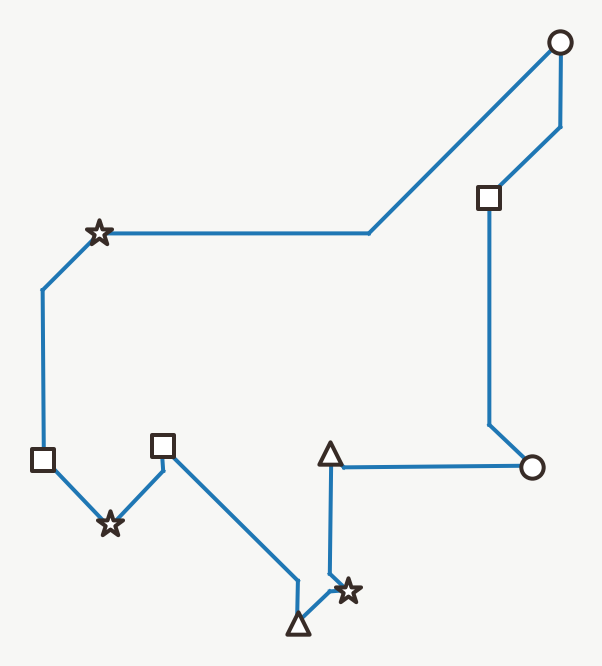

In [3]:
def tsp(city, verbose=True):
    
    n_stations = len(city.stations)
    
    dist = gen_distance_matrix(city)
    
    S = list(range(n_stations))
    subs = subsets(S)
    
    m = gp.Model()
    if not verbose:
        m.setParam('OutputFlag', 0)
    
    w = m.addVars(n_stations, n_stations, vtype=GRB.INTEGER, name="x")

    m.setObjective(gp.quicksum(dist[s1, s2]*w[s1, s2] for s1 in S for s2 in S if s1 != s2), GRB.MINIMIZE)

    # leave each station only once
    m.addConstrs(gp.quicksum(w[s1, s2] for s1 in S if s1 != s2 ) == 1 for s2 in S)
    # enter each station only once
    m.addConstrs(gp.quicksum(w[s1, s2] for s2 in S if s1 != s2 ) == 1 for s1 in S)
    # Subtour elimination constraints
    for sub in subs:
        m.addConstr(gp.quicksum(w[s1, s2] for s1 in sub for s2 in sub if s1 != s2) <= len(sub) - 1)

    m.optimize()
    
    return m
    
m = tsp(city, verbose=False)
best = pairs2rails([extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6])
graph(stations, best, equal_aspect=True, show_station_ids=False)

Stage 0 creates loops for both Box and 3-cluster test cases, even though more lines were available in each scenario. This is a major limiting factor in the formulation as loops going through every station are rarely good solutions.

**Figure 2**: An optimal TSP solution for 'Box'

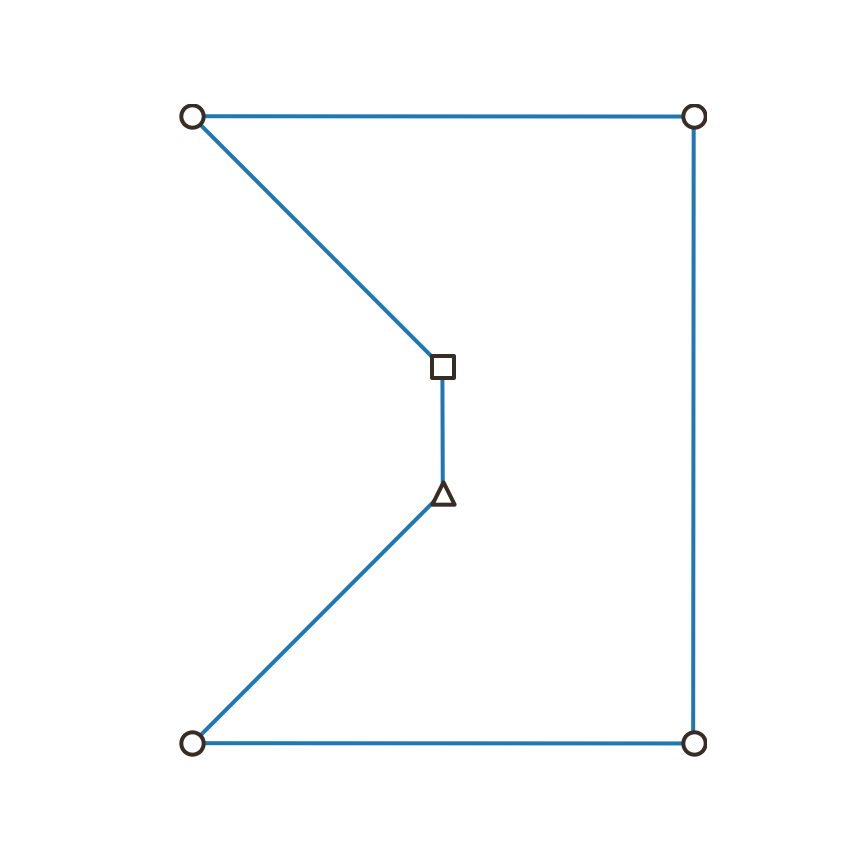
  

**Figure 3**: An optimal TSP solution for '3-Cluster'
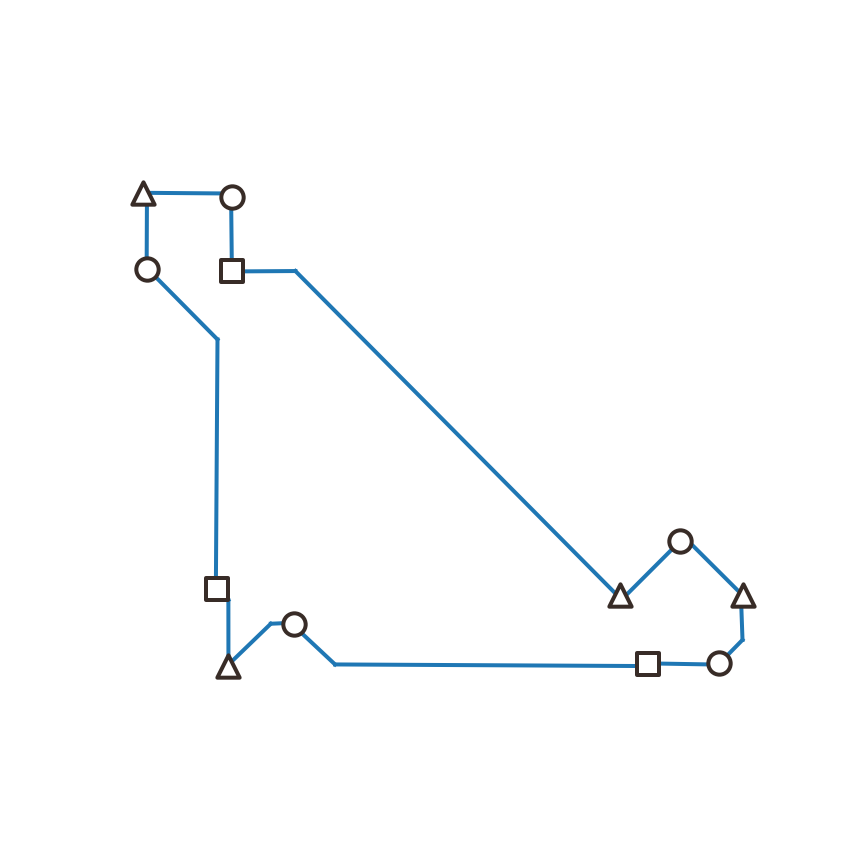

## 4. Stage 1

### Problem definition

We extend our formulation in Stage 0 to include multiple trains, whose rails are analogous to the paths of the travelling salesman. In general, the problem of multiple salesmen departing from multiple starting locations is exactly specified in the Multi-depot Multiple Travelling Salesman Problem (MmTSP), where every customer is visited once by one of the salesmen, who each depart from differing depots, and the goal is to minimise the total distance travelled on the tours in total. Typically, MmTSP models require that salesmen must return to either their depot of origin ("fixed depot") or any depot ("unfixed depot"). In our problem, there is no specific choice for depot, so to utilise the MmTSP formulation we introduce a fake 'dummy' depot; all rails start at this depot, leave to traverse the true station network, and then return to it at the end.

**Limitations**\
As with Stage 0, we are still simplifying our Mini Metro formulation, and so there are limitations in how we model our solutions. These limitations include: 
1.  Loops: it is not feasible for the train to travel in a loop in this model, and instead it must go back and forth along a line; whereas loops are a feasible rail design in the Mini Metro game.
2.	Homogeneous stations: at this stage we have not yet differentiated the stations into different kinds; the model merely seeks to minimise the rail lengths to connect stations
3.	No overlapping routes: in reality and in the game, we can have transfer stations that connect different routes, but MmTSP forces separate rails. Furthermore, due to the introduction of a dummy depot external to the actual stations requiring trains, it is possible for a feasible network to be completely disconnected. As heterogeneous stations are desirable, the network must be fully-connected for all possible passengers to travel to their destinations, irregardless of starting station.

### Model formulation

This formulation is an adaptation of the MmTSP formulation presented in Bektas et al. (2006), but was first encountered in the context of ant colony path modelling in Ghafurian et al. (2011). **For this reason, the model is sometimes referred to as the 'Ants' model in this paper.**

*Data*:\
$S$: the set of stations, not including the dummy depot\
$0$: the dummy depot\
$S_0 = S \cup \{0\}$: The set of stations, including the dummy depot\
$M$: The number of rails connecting stations (each with an independent train)\
$D = \{1,\dots,M\}$: The indexing set of $M$ rails\
$N = |S|$: the total number of stations\
$(x_i,y_i)$: the coordinates of station $i \in S$\
$c_{ij}$: the distance between stations $i, j \in S$\
$K$: the minimum number of stations a train can visit\
$L = N$: the maximum number of stations a train can visit


*Variables*: \
$w_{ijk} = \begin{cases} 1 & \text{the train on rail $k$ passes through the connecting stations $i$ and $j$}\\ 0 & \text{otherwise} \end{cases} \, \, \, \forall i, j\in S,\ k \in D$

$u_{i}$: the MTZ potential at station $i$ on rail/route $k$, $\forall i \in S$

*Objective*:

Minimise the leaving and entering cost for each depot and the path cost for non-depot arcs:

$z = \min \sum_{k\in D}\sum_{i \in S}\sum_{j \in S} c_{ij}w_{ijk}$

*Constraints*:

$w_{ijk}\in \{0, 1\} \, \, \, \forall i,j \in S, k\in D$\
$u_i \geq 0 \, \, \, \forall i \in S$


(1) Exactly 1 salesman (train) departs from each depot \
$\sum_{j \in S}w_{0jk} = 1, \, \, \, \forall k \in D$

(2) Each non-depot station is visited exactly once (each station only has one incoming arc)\
$\sum_{i\in S_0}\sum_{k \in D}w_{ijk} = 1, \, \, \, \forall j \in S$

(3) Route continuity for non-depot stations (edges going in = edges going out)\
$\sum_{i \in S_0}w_{ijk} - \sum_{i \in S_0}w_{jik} = 0, \, \, \, \forall k \in D, j \in S$

(4) Route continuity for depots (edges coming in = edges going out)\
$\sum_{j \in S}w_{0jk} - \sum_{j \in S} w_{j0k} = 0, \, \, \, \forall k \in D$

(5) Upper bound for $u_i$:\
$u_i + (L-2)\sum_{k \in D}w_{0ik} - \sum_{k \in D}w_{i0k} \leq L- 1, \, \, \, \forall i \in S$

(6) Lower bound for $u_i$:\
$u_i + \sum_{k \in D}w_{0ik} + (2-K)\sum_{k \in S}w_{i0k} \geq 2, \, \, \, \forall i \in S$

(7) Tours with just one station are prohibited\
$\sum_{k \in D} w_{0ik} + \sum_{k \in D} w_{i0k} \leq 1, \, \, \, \forall i \in S$

(8) MTZ Subtour elimination constraints\
$u_i - u_j + L\sum_{k \in D}w_{ijk} + (L-2)\sum_{k\in D}w_{jik} \leq L -1, \, \, \, \forall i, j \in S \, \, \, \text{s.t. }i \neq j$

### Model implementation and solution

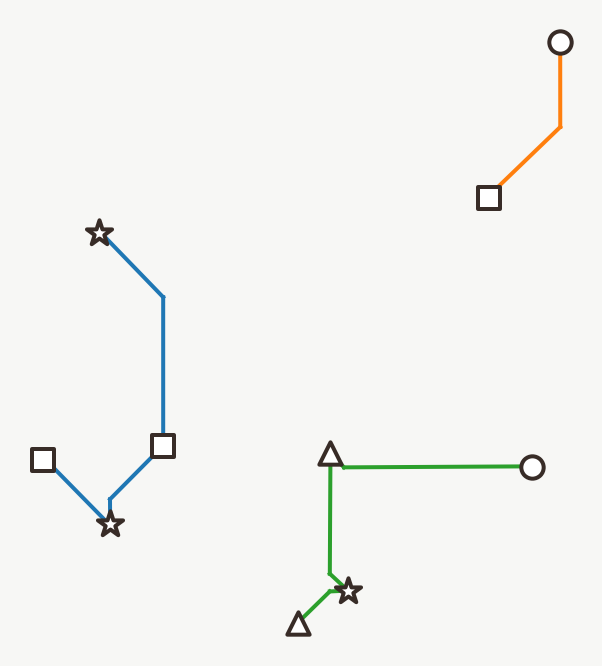

In [4]:
from ast import literal_eval

def ants(city, verbose=True):
    n_stations = len(city.stations)
    S = list(range(n_stations))
    dist = gen_distance_matrix(city)
    subs = subsets(S)
    
    DUMMY = n_stations
    M = 3
    D = range(M)
    S0 = S + [DUMMY]
    K = 1
    L = 100
    mk = 1

    m = gp.Model()
    if not verbose:
        m.setParam('OutputFlag', 0)

    w = m.addVars(n_stations+1, n_stations+1, M, vtype=GRB.BINARY, name="w")
    u = m.addVars(n_stations, vtype=GRB.INTEGER, name="u")

    m.setObjective(gp.quicksum(dist[i, j]*w[i, j, k] for k in D for j in S for i in S), GRB.MINIMIZE)
    m.addConstrs(gp.quicksum(w[DUMMY, j, k] for j in S) == mk for k in D)
    m.addConstrs(gp.quicksum(w[i, j, k] for i in S0 for k in D) == 1 for j in S)
    m.addConstrs(gp.quicksum(w[i, j, k] for i in S0) - gp.quicksum(w[j, i, k] for i in S0) == 0
                 for k in D for j in S)
    m.addConstrs(gp.quicksum(w[DUMMY, j, k] for j in S) - gp.quicksum(w[j, DUMMY, k] for j in S) == 0 for k in D)
    m.addConstrs(u[i] + (L - 2)*gp.quicksum(w[DUMMY, i, k] for k in D) - 
                 gp.quicksum(w[i, DUMMY, k] for k in D) <= L - 1 for i in S)
    m.addConstrs(u[i] + gp.quicksum(w[DUMMY, i, k] for k in D) + (2 - K)*gp.quicksum(w[i, DUMMY, k] for k in D) >= 2 for i in S)
    m.addConstrs(gp.quicksum(w[DUMMY, i, k] for k in D) + gp.quicksum(w[i, DUMMY, k] for k in D) <= 1 for i in S)
    m.addConstrs(u[i] - u[j] + L*gp.quicksum(w[i, j, k] for k in D) + 
                 (L - 2)*gp.quicksum(w[j, i, k] for k in D) <= L - 1 for i in S for j in S if i != j)
    m.addConstrs(w[i, i, k] == 0 for i in S for k in D)

    m.optimize()
    return m

m = ants(city, verbose=False)

SOURCE_IDX = 0
TARGET_IDX = 1
RAIL_IDX = 2
DUMMY = len(city.stations)

# Modified connections definition to disquality report of dummy depot-related edges
connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'w' and \
                  literal_eval(v.varName[1:])[SOURCE_IDX] != DUMMY and literal_eval(v.varName[1:])[TARGET_IDX] != DUMMY]

rail_pairs = dd(list)
for connection in connections:
    rail_pairs[connection[RAIL_IDX]].append(connection[:2])
    
rails = []

for rail, pairs in rail_pairs.items():
    rails.append(pairs2rails(pairs))
    
graph(stations, rails, equal_aspect=True, show_station_ids=False)

Stage 1 does not perform well on the Box test case. Note that Ants creates two isolated components, but each component is missing a station kind. This means that passengers will pile up and the game will be lost if this solution is used. On the other hand, Ants yields a very good solution in the 3-cluster test case where each isolated component happens to contain every kind of station. This limitation of course comes from Ants not modelling each kind of station, but attempting to use isolated components when it can promote much shorter rails.

**Figure 4**: An optimal Stage 1 solution for 'Box'
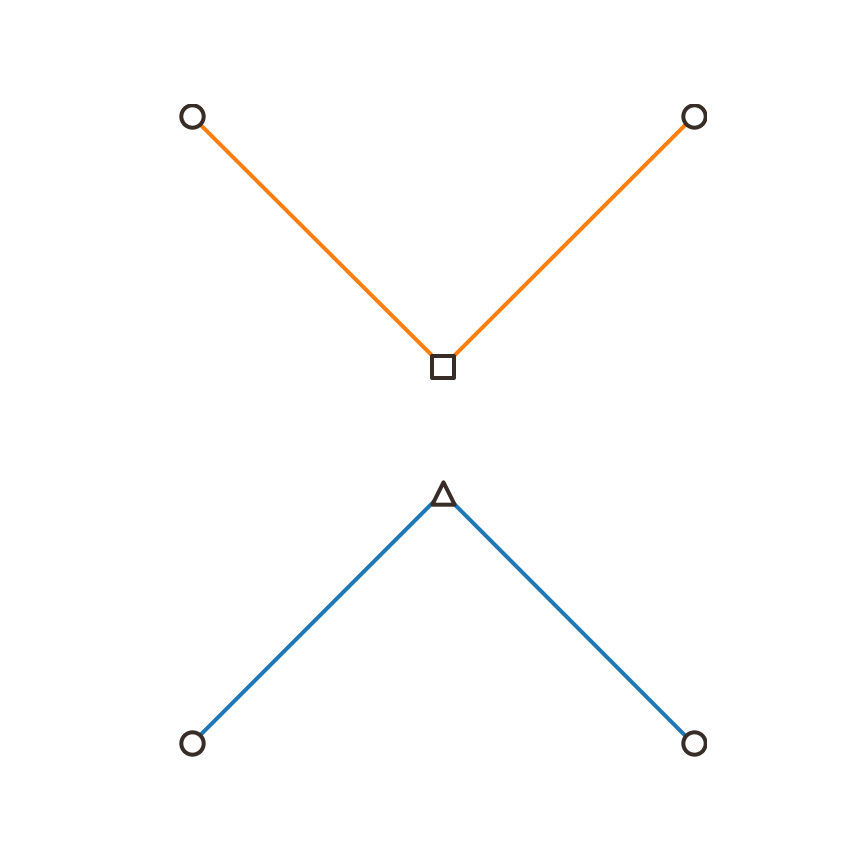


**Figure 5**: An optimal Stage 1 solution for '3-Cluster'
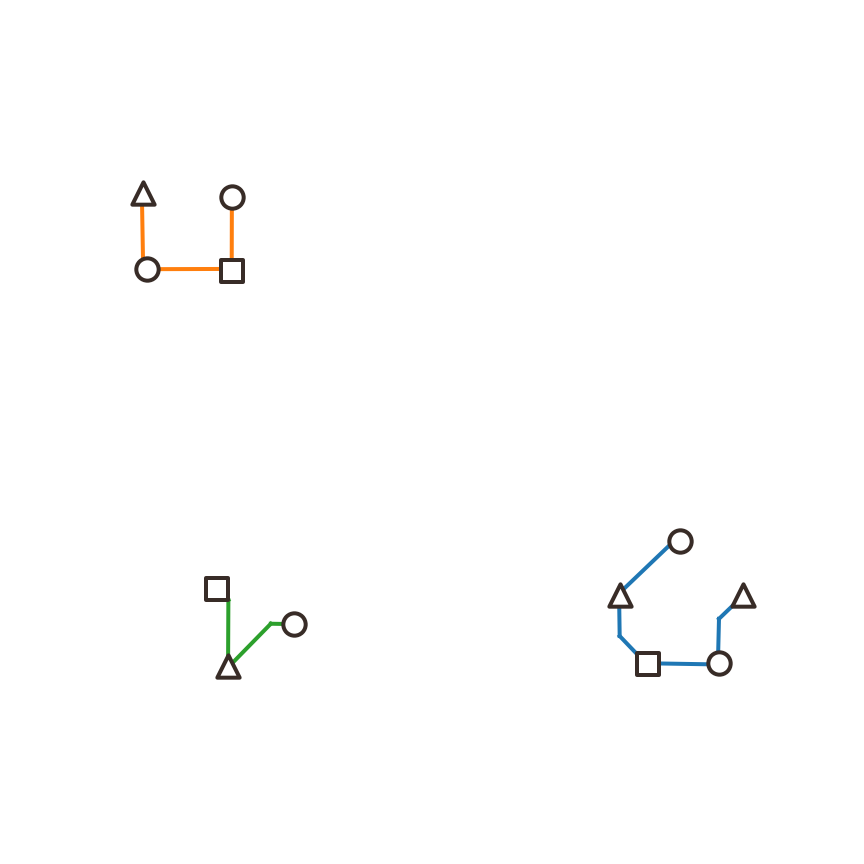


## 5. Stage 2

### Problem definition 

Here we introduce a MIP model that, in addition to the homogeneous-station, depot-free, multiple-rail specification introduced in Stage 1, allows rail crossovers and looped tracks in (feasible) solutions, and furthermore forces the network to be fully-connected (so that passengers can navigate to any other station).



Our approach was to adapt the Split-Delivery Vehicle Routing Problem (SDVRP) formulation introduced in Dror et al. (1994), an extension of the classic Vehicle Routing Problem (VRP), with additional constraints to encourage a fully-connected network. 

The VRP model works with $M$ homogeneous vehicles of capacity $Q$ starting at a depot, seeking to find non-overlapping routes of minimal travel cost through a network of $N$ customers with individual demands - such that all customer demands are satisfied, without overburdening any vehicles, and where vehicles return to the depot afterwards.

SDVRP differs from VRP in that the demands of each customer may exceed the largest capacity vehicle, which forces vehicles to work together to meet customer demands; as such, solutions may have overlapping routes within a MIP formulation.

Noteworthy changes made to the SDVRP formulation to apply the formulation to our problem were as follows:

1. A 'dummy' depot was used as in Stage 1 to remove any need to choose a depot from the homogeneous stations.
2. The capacity of each train/rail is set to the number of stations ($Q = N$), and unit demands are assigned to each station.
3. The DFJ Subtour Elimination Constraints (SEC's) originally used in the SDVRP formulation were replaced with Miller-Tucker-Zemlin (MTZ) SEC's.
4. The MTZ SEC's were modified to not only apply on a per-route basis (to allow different MTZ potentials for stations on each rail), but are now disjunctive constraints that conditionally deactivate to allow loops.

<!-- **TODO**: CITATIONS FOR THE DFJ AND MTZ CONSTRAINTS? -->

In addition, flow formulation variables and constraints were added to ensure rails formed a fully-connected graph. This was mostly adapted from Gavish and Graves (1978), who introduce a network flow formulation for the TSP that also happens to enforce that all nodes be connected in a graph. This required modification so that the constraints could reconcile the overlapping connections from multiple rails in a solution; this was done by introduction of the variable $e_{ij}$ in place of $x_{ij}$ (see model below).

Furthermore, this specification requires specifying a root or sink that the other stations feed into. If we note $\mathbf{r}(s)\in\mathcal{R}^2$ as the location of station $s$, and define the mean station location as $\bar{\mathbf{r}} = \frac{1}{N}\sum\limits_{s\in S} \mathbf{r}(s)$, our strategy is to set the root as the closest station to this mean according to euclidean distance - i.e. $r := \underset{s\in S}{\arg\min} ||\mathbf{r}(s) - \bar{\mathbf{r}}||$.

Note that a fully-connected rail network is not strictly necessary in every Mini Metro instance; for example, it is not needed if there are multiple well-separated clusters of stations, each with the same station kinds (as in '3-Cluster'). However, as there are station kinds that occur only once (and hence require a fully-connected rail system to be reached by all passengers), these constraints are justified in application.

Overall, these extensions provide an MIP formulation with loops, crossing rails, unspecified depots and connected networks in its feasible solutions.

**Limitations**

As with the previous stages, the model still ignores any notion of station and passenger kinds, passenger movement or transfers, or train movement and travel time through a network as previously discussed, to allow a mixed-integer formulation. An attempt to provide realistic solutions for Mini Metro instances (i.e. that improves on the feasible space of the Stage 2 MIP to factor in kinds and transfers) is discussed in Stage 3. 

A new limitation introduced in Stage 2 is in the flow formulation. Referencing the model specification's fully-connected flow constraints, constraints (F1) and (F5) together require a rail both entering and exiting the root. As a result, certain choices of $r$ that would be optimally situated at the end or start of a rail are **incorrectly dismissed** as infeasible. Our strategy for choosing a centrally-located station as $r$ specified above aims to avoid dismissing as few feasible solutions as possible, but ultimately the current implementation is not guaranteed to yield optimal solutions for the simplified problem we aimed to solve.

This issue appears addressable if we modify the flow formulation to allow flow bidirectionally along an edge even if there is only one direction of rail (see below). However doing so drastically hurts our model performance (increasing time complexity by a factor of 1000 in the worst case).

(F6\*, F7\*) Modified lower and upper bounds to define $e_{ij}$\
$e_{ij} \leq \frac{1}{2} + \sum\limits_{k\in D} w_{ijk} + \sum\limits_{k\in D} w_{jik}\quad\forall i,j\in S$

$e_{ij} \geq C^{-1}\sum\limits_{k\in D}w_{ijk} + C^{-1}\sum\limits_{k\in D} w_{jik}\quad\forall i,j\in S$

### Model formulation 


*Data*:\
$S$: the set of stations, not including the dummy depot\
$0$: the dummy depot\
$S_0 = S \cup \{0\}$: The set of stations, including the dummy depot\
$M$: The number of rails connecting stations (each with an independent train)\
$D$: The indexing set of $M$ rails\
$N = |S|$: the total number of stations\
$(x_i,y_i)$: the coordinates of station $i \in S$\
$c_{ij}$: the distance between stations $i, j \in S$\
$K$: the minimum number of stations a train can visit\
$D = \{1,\dots,M\}$: Indices for each rail\
$Q = n$: The capacity of each train / rail\
$d_i = 1$: The demand of the $i$th station\
$m_k = 1$: The number of trains on the $k$th rail\
$r$: The station/node nominated as the flow root; used for connectivity constraints\
$C = 10^9$: Big-M / large constant \

<!-- **TODO**: HOW BADLY SHOULD C BE CHANGED TO M INSTEAD? -->

*Variables*:\
$w_{ijk}$: Indicator for when the $i$th station connects to the $j$th station on rail $k$\
$y_{ik}$: The fractional demand met for the $i$th station on rail $k$\
$u_{ik}$: The potential for the $i$th station on rail $k$\
$p_{ij}$: Inter-station flow from station $i$ to $j$; used for connectivity constraints\
$e_{ij}$: Indicator for whether a rail directly connects station $i$ and $j$, in either direction, on any rail

*Objective*: $$z=\min \sum_{i=1}^{n} \sum_{j=1}^{n} c_{i j} x_{i j k}\quad(1)$$

*Constraints*:

**Connectivity Constraints**

$w_{i j k} \in\{0,1\}, \quad i, j\in S_0, \ k\in D$

$y_{i k} \geq 0, \quad i\in S, \ k\in D$

$u_{i k} \geq 0, \quad i\in S, \ k\in D$

$p_{i j} \geq 0, \quad i, j\in S$

$e_{i j} \in\{0,1\}, \quad i, j\in S$

(1) At least one connection should enter each station, and the depot\
$\sum\limits_{i\in S_0} \sum\limits_{k\in D} w_{ijk} \geq 1\quad\forall j\in S_0$

(2) Total number of connections in should match connections out, on a per-rail basis\
$\sum\limits_{i\in S_0} w_{ijk} = \sum\limits_{i\in S_0} w_{jik}\quad\forall j\in S_0,\ k\in D$

(3) Connections cannot be made with a station to itself\
$w_{iik} = 0 \quad\forall i\in S_0,\ k\in D$

(4) Each rail must leave the depot exactly $m_k$ times\
$\sum\limits_{i\in S} w_{i0k} = m_k\quad\forall k\in D$

(5) Each rail must enter the depot exactly $m_k$ times\
$\sum\limits_{i\in S} w_{0ik} = m_k\quad\forall k\in D$

(6) Rails cannot cross the same connection twice (unless that connection is to the depot)\
$w_{ijk} + w_{jik} \leq 1\quad\forall i, j\in S,\ k\in D$

(7) Rails must be at least $K$ station-to-station connections long\
$\sum\limits_{i\in S_0}\sum\limits_{j\in S_0}w_{ijk} \geq K\quad\forall k\in D$

**Subtour Elimination Constraints (SECs)**

(8) MTZ SEC's applied per-route, excluding the loop case where $i$ connects to $j$ and also $j$ connects to $0$ on rail $k$\
$u_{ik} - u_{jk} + Nw_{ijk} \leq N-1 + Nw_{j0k}\quad\forall i\in S,\ j\in S \backslash \{i\},\ k\in D$

**Demand and Capacity Constraints**

(9) Can only satisfy demand by the $k$th rail if there is a connection on that rail passing through\
$ y_{ik} \leq d_i \sum\limits_{j\in S_0} w_{ijk} \quad\forall i\in S,\ k\in D$

(10) Total satisfied demand at a station must match its demand\
$\sum\limits_{k\in D} y_{ik} = d_i \quad \forall i\in S$

(11) Total satisfied demand on a rail cannot exceed capacity\
$\sum\limits_{i\in S} y_{ik} \leq Q\quad\forall k\in D$

**Fully-connected Flow Constraints**

<!-- **TODO**: I REFER TO THE CONSTRAINTS BELOW WHEN DISCUSSING LIMITATIONS. IF YOU CHANGE THE NUMBERING/INDEXING, PLEASE CHANGE APPROPRIATELY IN THE LIMITATION DISCUSSION TOO. -->

(F1) A unit flow must exit the root\
$\sum\limits_{j\in S \backslash\{r\}} p_{rj} = 1$

(F2) Stations cannot flow into themselves\
$p_{ii} = 0,\quad\forall i\in S$

(F3) Flow can only occur where a rail is in place\
$p_{ij} \leq Ne_{ij},\quad\forall i \in S, j\in S \backslash\{i\}$

(F4) Non-root nodes must contribute net one extra flow unit to the network\
$\sum\limits_{j\in S}p_{ij} - \sum\limits_{j\in S}p_{ji} = 1\quad\forall i\in S \backslash\{r\}$

(F5) Flow into the root must total $N$\
$\sum\limits_{i\in S} p_{ir} = N$

(F6, F7) Lower and upper bounds to define $e_{ij}$\
$e_{ij} \leq \frac{1}{2} + \sum\limits_{k\in D} w_{ijk}\quad\forall i,j\in S$

$e_{ij} \geq C^{-1}\sum\limits_{k\in D}w_{ijk}\quad\forall i,j\in S$


### Model implementation and solution

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1018 rows, 623 columns and 4737 nonzeros
Model fingerprint: 0x935231a0
Variable types: 160 continuous, 463 integer (463 binary)
Coefficient statistics:
  Matrix range     [1e-08, 1e+01]
  Objective range  [2e-01, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+01]
Presolve removed 333 rows and 53 columns
Presolve time: 0.01s
Presolved: 685 rows, 570 columns, 3660 nonzeros
Variable types: 150 continuous, 420 integer (420 binary)

Root relaxation: objective 2.507232e+00, 364 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.50723    0   41          -    2.50723      -     -    0s
H    0     0                      11.9047222    2.50723  78.9%     -    0s
H

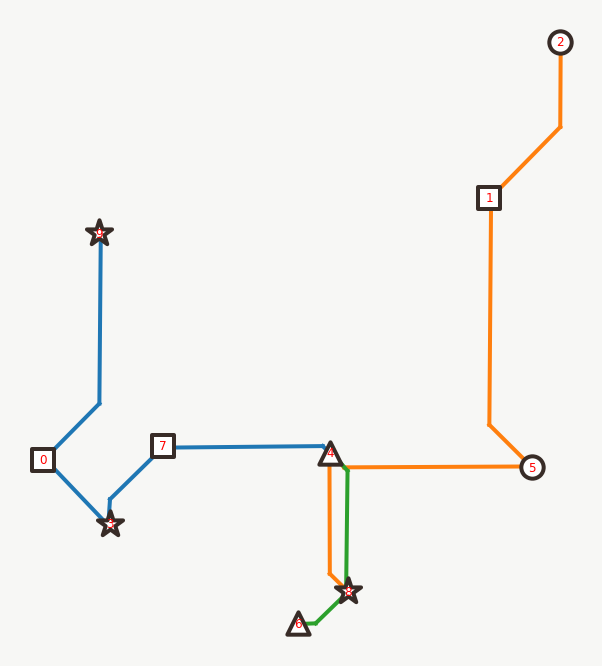

In [5]:
def choose_flow_root(city, debug=False):
    """Returns id of most central station for flow root"""
    positions = np.array(list(map(lambda s: [s.x, s.y], city.stations)))
    mean = positions.sum(0) / len(city.stations)
    if debug: print("Mean: ", mean)
    
    best_s, best_dist = None, 10e5
    for s in city.stations:
        dist = np.linalg.norm(mean - np.array([s.x, s.y]))
        if debug: print((s, s.x, s.y, dist))
        if dist < best_dist:
            best_s, best_dist = s, dist
    
    return best_s.id

def sdvrp(city, verbose=True):
    n = n_stations = len(city.stations)  # no. customers
    M = 3  # no. rails
    D = range(M) # set of vehicles
    S = list(range(n_stations))  # customers
    DUMMY = n  # dummy depot's index
    S0 = S + [DUMMY]  # customers + depot

    d = [1]*n # Customer demands, set to unit
    Q = n  # capacities of vehicles (assumed homogenous)
    K = 1 # min number of visited stations (excluding depot)
    mk = 1 # Num trains from kth depot
    dist = gen_distance_matrix(city)   # cost matrix
    C = 10e7   # Big-M

    m = gp.Model()
    if not verbose:
        m.setParam('OutputFlag', 0)

    w = m.addVars(n_stations+1, n_stations+1, M, vtype=GRB.BINARY, name="w") # node i --> node j on path of vehicle k
    y = m.addVars(n_stations, M, lb=0.0, name="y")  # quantity of ith site's demand satisfied by kth vehicle/route
    u = m.addVars(n_stations, M, lb=0.0, name="u")  # MTZ potentials
    p = m.addVars(n_stations, n_stations, lb=0.0, name="p") # Whole-network flow potentials
    e = m.addVars(n_stations, n_stations, vtype=GRB.BINARY, name="e") # indicators for edge use

    m.setObjective(gp.quicksum(dist[i,j]*w[i,j,k] for i in S for j in S for k in D), GRB.MINIMIZE)
    
    ### FLOW CONSTRAINTS FOR A FC GRAPH
    FLOW_ROOT = choose_flow_root(city)
    # A flow of 1 must exit the 'root'
    m.addConstr(gp.quicksum(p[FLOW_ROOT,j] for j in S if j != FLOW_ROOT) == 1) 
    # cannot have self-flows
    m.addConstrs(p[i,i] <= 0 for i in S)
    # Outflow - Inflow = 1 for non-roots (i.e. all nodes increase flow by one)
    m.addConstrs(gp.quicksum(p[i,j] for j in S) - gp.quicksum(p[j,i] for j in S) == 1 for i in S if i != FLOW_ROOT)
    # Flow can only occur where an edge is formed
    m.addConstrs(p[i,j] <= (n_stations)*e[i,j] for i in S for j in S if i != j)
    # Flow into the root must be N for any edge going into it
    m.addConstrs(gp.quicksum(p[i, FLOW_ROOT] for i in S) == n_stations for i in S if i != FLOW_ROOT)
    # Edge-indicator setup
    m.addConstrs(e[i,j] <= 0.5 + gp.quicksum(w[i,j,k] for k in D) for i in S for j in S)
    m.addConstrs(e[i,j] >= gp.quicksum(w[i,j,k] for k in D) / C for i in S for j in S)

    ### EDGE CONSISTENCY CONSTRAINTS
    # At least one edge enters every j (including the depot)
    m.addConstrs(gp.quicksum(w[i,j,k] for i in S0 for k in D) >= 1 for j in S0)
    # in == out for every node + depot, per-route basis (and hence in general)
    m.addConstrs((gp.quicksum(w[i,j,k] for i in S0) - gp.quicksum(w[j,i,k] for i in S0) == 0 for j in S0 for k in D))

    ### SUBTOUR CONSTRAINTS 
    # SEC using MTZ
    m.addConstrs((u[i,k] - u[j,k] + n_stations*w[i,j,k] <= n_stations-1 + \
                      n_stations*w[j,DUMMY,k] for i in S for j in S if i != j for k in D))

    ### DEMAND CONSTRANTS
    # ith demand can only be sated by route k if there's an outbound edge from i on that path
    m.addConstrs(y[i,k] <= d[i]*gp.quicksum(w[i,j,k] for j in S0) for i in S for k in D)
    # Total sated demand @ i must meet demand
    m.addConstrs(gp.quicksum(y[i,k] for k in D) == d[i] for i in S)
    # Total sated demand by k cannot exceed capacity of vehicle
    m.addConstrs((gp.quicksum(y[i,k] for i in S) <= Q for k in D))

    ### OTHER constraints
    # No self-joins
    m.addConstrs(w[i,i,k] <= 0 for i in S0 for k in D)
    # For a given k, you must (and only once) enter the dummy depot, and leave the dummy depot
    m.addConstrs(gp.quicksum(w[i,DUMMY,k] for i in S) == mk for k in D)
    m.addConstrs(gp.quicksum(w[DUMMY,i,k] for i in S) == mk for k in D)
    # Same vehicle cannot cross the same connection twice (excluding depot)
    m.addConstrs((w[i,j,k] + w[j,i,k] <= 1 for i in S for j in S for k in D))
    # Routes must have more than K edges (K >= 1)
    m.addConstrs((gp.quicksum(w[i,j,k] for i in S for j in S) >= K for k in D))

    m.optimize()
    
    return m
    
m = sdvrp(city)

SOURCE_IDX = 0
TARGET_IDX = 1
RAIL_IDX = 2
DUMMY = len(city.stations)

connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'w' and \
                  literal_eval(v.varName[1:])[SOURCE_IDX] != DUMMY and literal_eval(v.varName[1:])[TARGET_IDX] != DUMMY]

rail_pairs = dd(list)
for connection in connections:
    rail_pairs[connection[RAIL_IDX]].append(connection[:2])
    
rails = []

for rail, pairs in rail_pairs.items():
    rails.append(pairs2rails(pairs, debug=False))
    
graph(stations, rails, jitter=True, equal_aspect=True)

**Figure 6**: An optimal Stage 2 solution for 'Box'
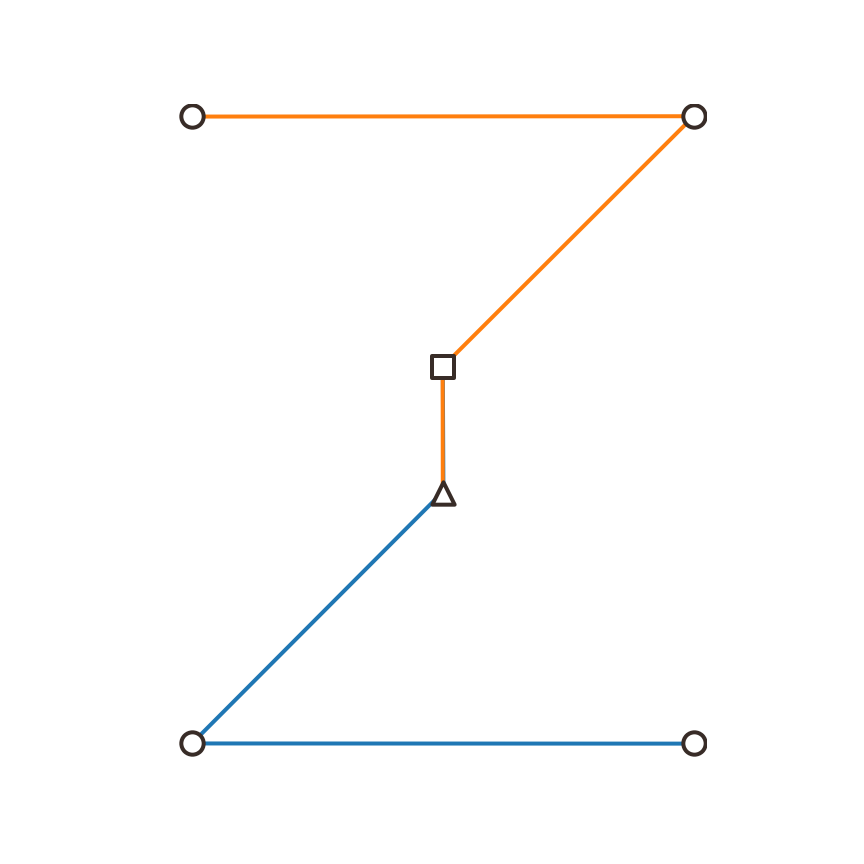

**Figure 7**: An optimal Stage 2 solution for '3-Cluster'
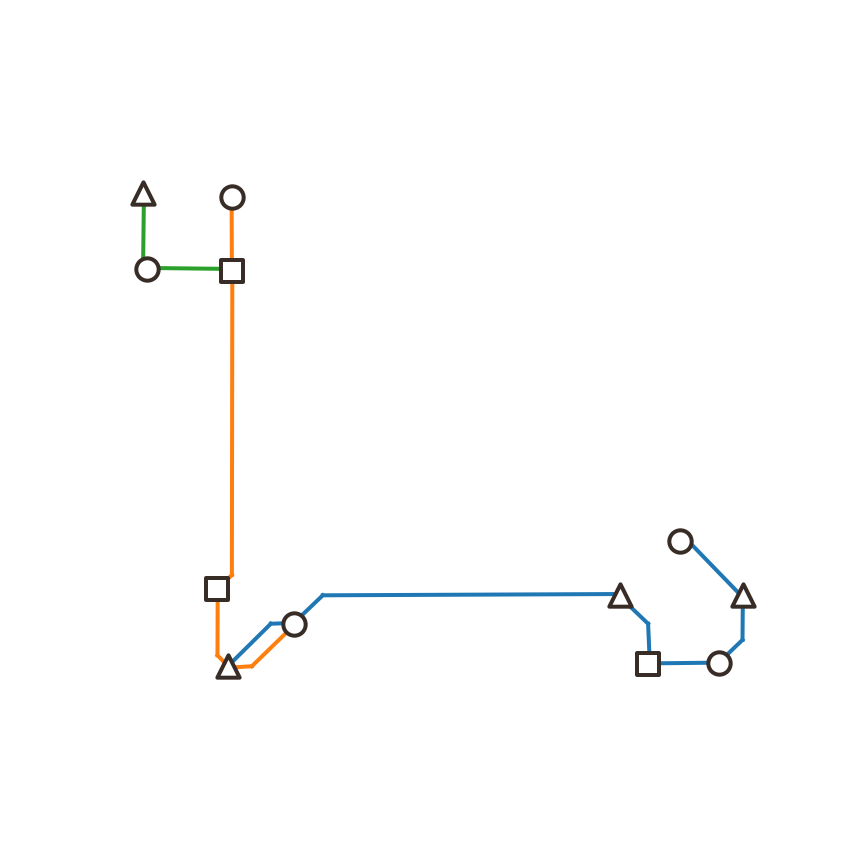

## 6. Stage 3

### Problem definition

As an extension, in order to generate even better solutions for the original problem, we deviate from linear programming and implement simulated annealing (Bertsimas, 1993). For large $N$, stages 0-2 quickly become intractable without implemented special computational tricks. Meanwhile, Simulated Annealing (SA) can run for much larger $N$, and importantly, can be terminated earlier at the users' discretion. This means that poor solutions can be attained quickly, or users can choose to let the algorithm run longer for better results. 

SA works by randomly modifying solutions until improvements are found. A greedy implementation would only ever take strictly better solutions, but this would almost always lead to poor local minima. Instead, it uses a parameter called ``temperature'' as the probability of accepting a randomly generated solution regardless of solution quality. This forces the algorithm to explore the solution space instead of stepping down to a local minima on the cost surface. The temperature decays exponentially across iterations and the algorithm becomes greedier - eventually almost exclusively accepting strictly better solutions.

The most important part of the algorithm is the cost function: how do we measure how good a solution is? The cost function evaluates solution quality with a few steps:

1. Approximate travel time between all stations. This includes modelling waiting times for trains on longer lines and transfer times between lines.

2. Calculate the quickest path from every station to every other station according to these times.

3. For each station: Total the shortest distance to each other `kind' of station. For example, a given square station may look to the closest circle and triangle station then sum those distances. If any kinds cannot be reached, that cost is Big $M$.

4. The final cost is the addition of two components: 1) the sum of these totalled distances, and 2) the total length of all lines divided by Big $M$.

### Model formulation and solution strategy 

The simulated annealing code is very long, complex, and does not involve any explicit linear programming or Gurobi. Because of this, pseudo-code has been included here but the associated code has been excluded. See related files `metro_utils.py` and `Simulated Annealing.ipynb` for the implementation.

#### Simulated Annealing
Simulated annealing takes two parameters: The number of iterations to perform, and the cutoff value. The number of iterations describes how many random changes to try before returning the best solution found. The cutoff value determines the minimum temperature before the function terminates. If $T$ is the temperature, $i$ is the iteration number, $\varepsilon$ is the cutoff value and $I$ is the number of iterations, the the temperature at iteration $i$ is given as:

$T(i) = \exp(i\ln(\varepsilon)/I)$

Lastly, for large $N$, simulated annealing will still regularly settle on a local minima, even if it is a reasonably good solution. In order to overcome this, the algorithm can be run multiple times (i.e. ``restarted'') and the best solution from all restarts is taken as the final solution.

With that in mind, here is the SA pseudo-code for a single restart:

```
curr_solution = random_initialise();
temperature = 1;

while temperature > ε
  test_solution = random_change(curr_solution);
  if cost(test_solution) < cost(curr_solution) or random_uniform(0, 1) < temperature
    curr_solution = test_solution;

  temperature = exponential_decay(temperature);
```

#### Random changes
As exhibited in the above pseudo-code, a key feature of SA is the exploration of `neighbouring' solutions by making small random changes. The random changes must be able to reach any solution in the solution space. The function works by uniformly randomly picking a number of lines to attempt to modify. For each line it chooses to modify, it will pick a random number from 1 to 4 to decide what type of modification to make. The cases are briefly outlined here:

1. Expand the end of the line.
If the line is a loop, nothing happens. Otherwise, the function randomly picks an end of the line and a station not currently in the middle of the line to create a new segment. This could potentially create a loop.

2. Shrink the end of the line.
If the line is a loop, the loop will be broken at a random point. Otherwise, the function randomly picks an end of the line and shortens it by one segment. If this results in the line disappearing altogether, then the change is undone.

3. Add station to middle of line.
If the line already connects every station, nothing happens. Otherwise, the function randomly picks a segment on the line and a station not on the line, then connects the line to that station by splitting the segment.

4. Remove station to middle of line.
If line connects only two stations, nothing happens. Otherwise, the function randomly picks a station in the middle of the line and removes the segments either side of the station, creating a single new segment in its place.

Here is the pseudo-code for the random change function:
```
lines_to_change = pick(lines);

for line in lines_to_change
    case = randint(1, 4);
    
    if case == 1
        if not has_loop(line)
            line = expand_end_of_line(line);

    if case == 2
        if has_loop(line)
            line = randomly_break_loop(line);
        else
            line = shrink_end_of_line(line);

    elif case == 3
        if len(line) < N
            line = add_station_in_middle(line);

    elif case == 4
        if len(line) > 2
            line = remove_station_in_middle(line);
```
**Figure 8**: Example 2-rail network and general adjacency matrix

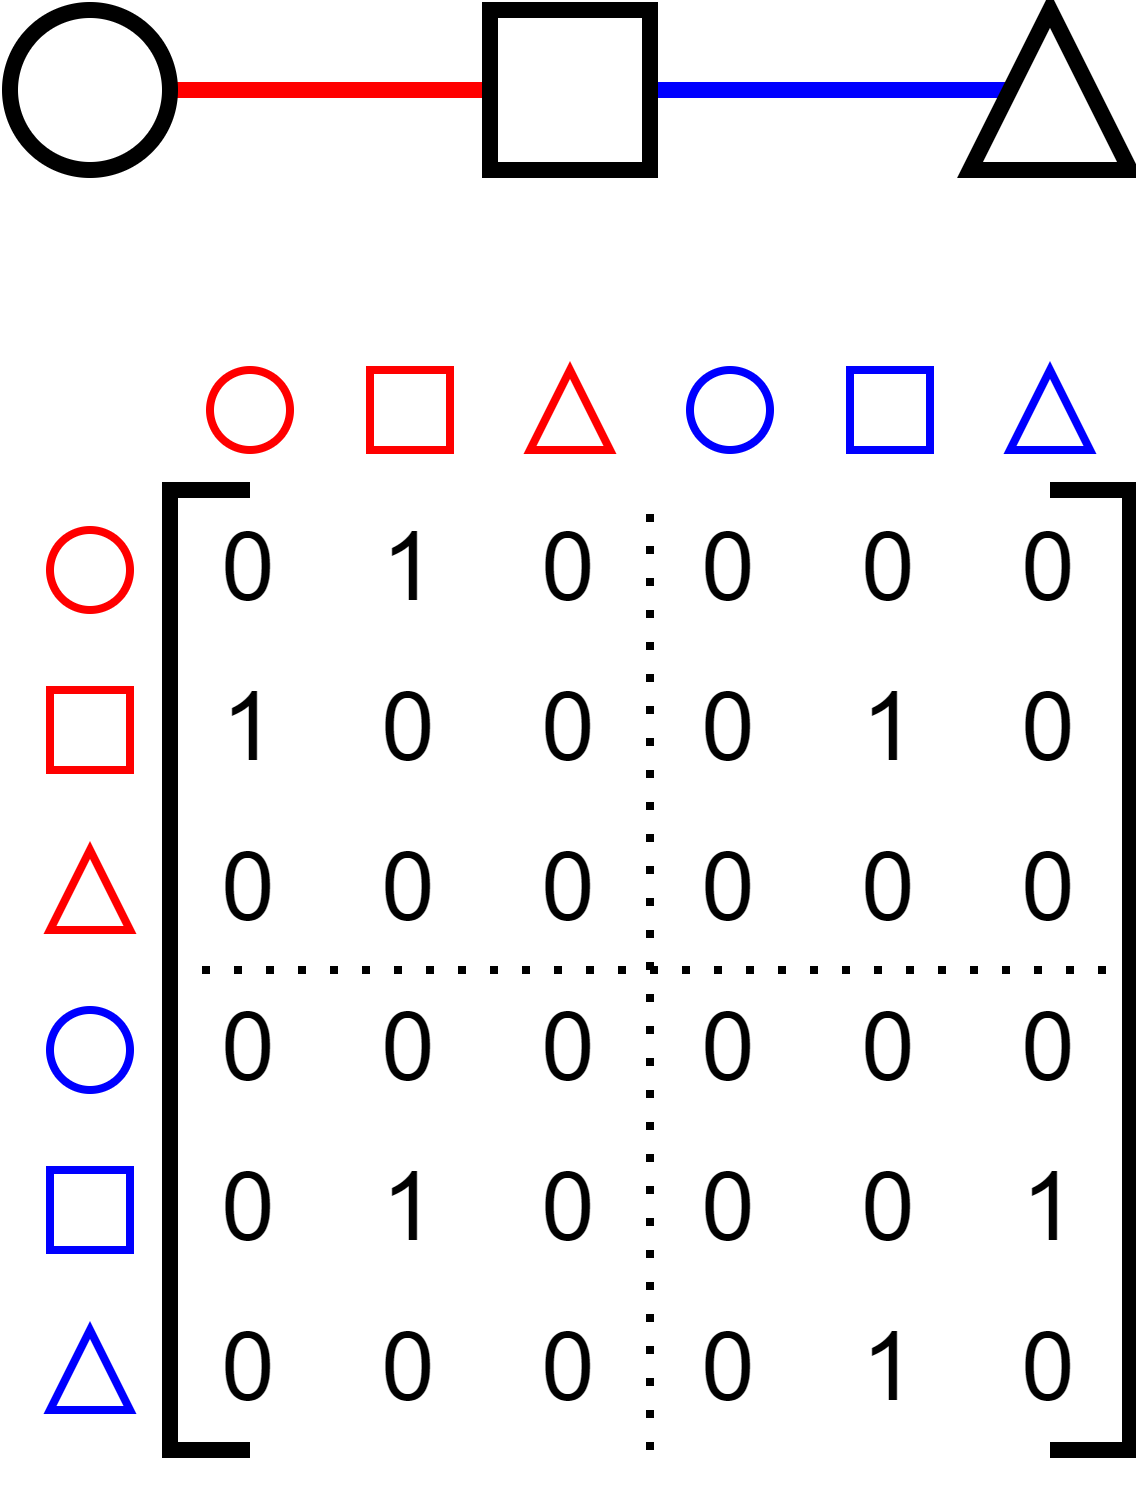

**Figure 9**: Simple A-B rail network 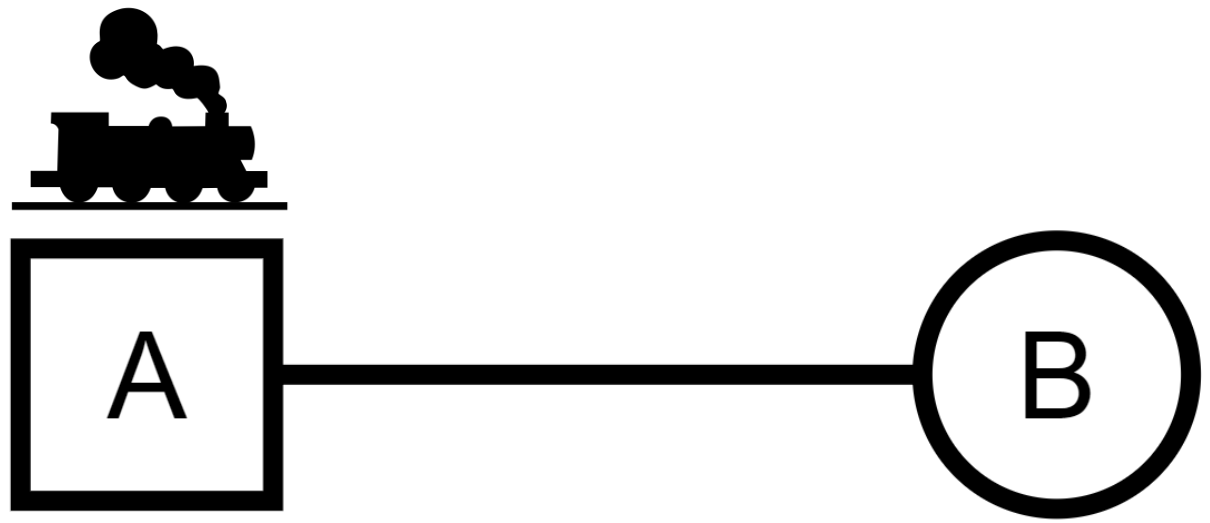

### Model implementation and solution 

**Figure 10**: A Simulated Annealing solution for 'Box'
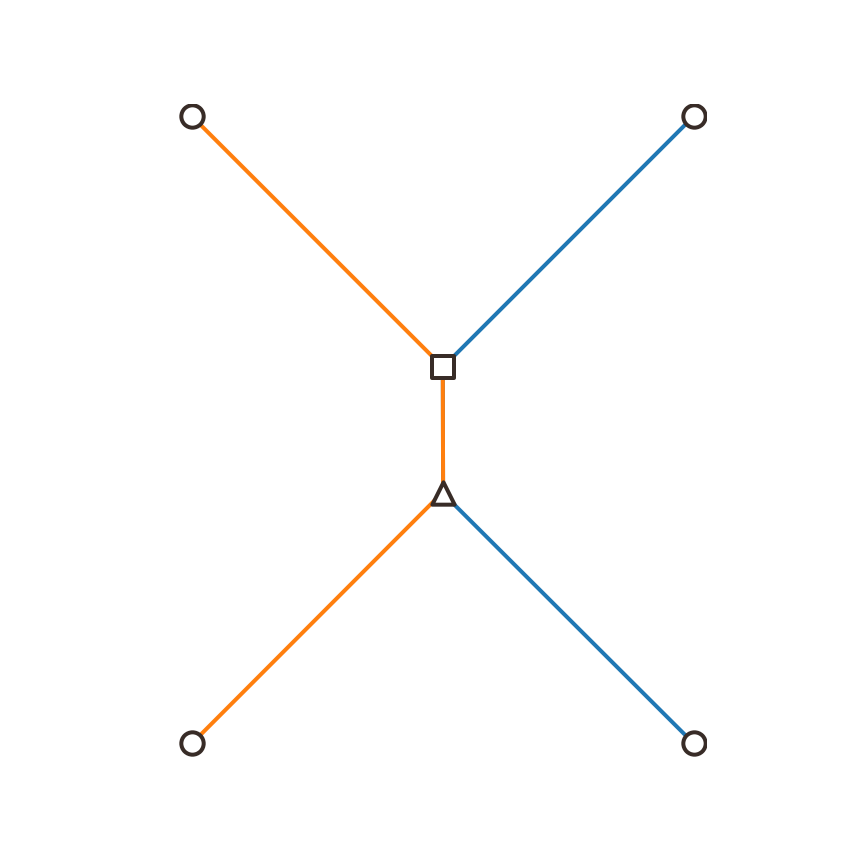


**Figure 11**: A Simulated Annealing solution for '3-Cluster'

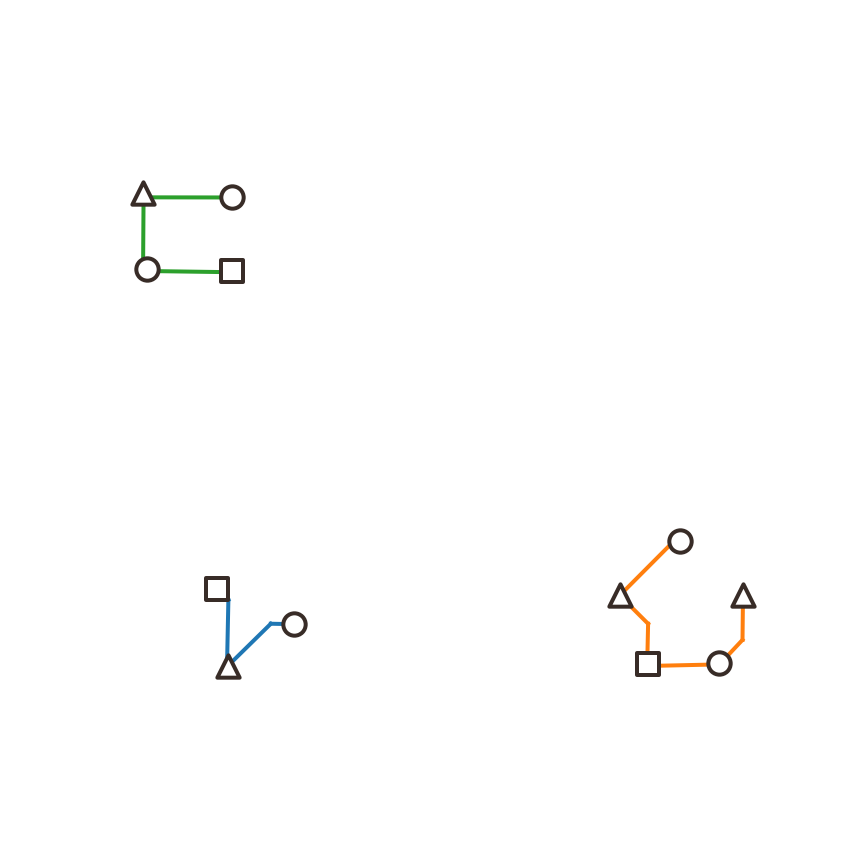

## 7. Validation and analysis



```
curr_solution = random_initialise()
temperature = 1

while temperature > ε:
  test_solution = random_change(curr_solution)
  if cost(test_solution) < cost(curr_solution) or random_uniform(0, 1) < temperature:
    curr_solution = test_solution

  temperature = exponential_decay(temperature)
```
**Figure 12**: Cost Comparison for Simulated Annealing dependent on Iterations and Station Count

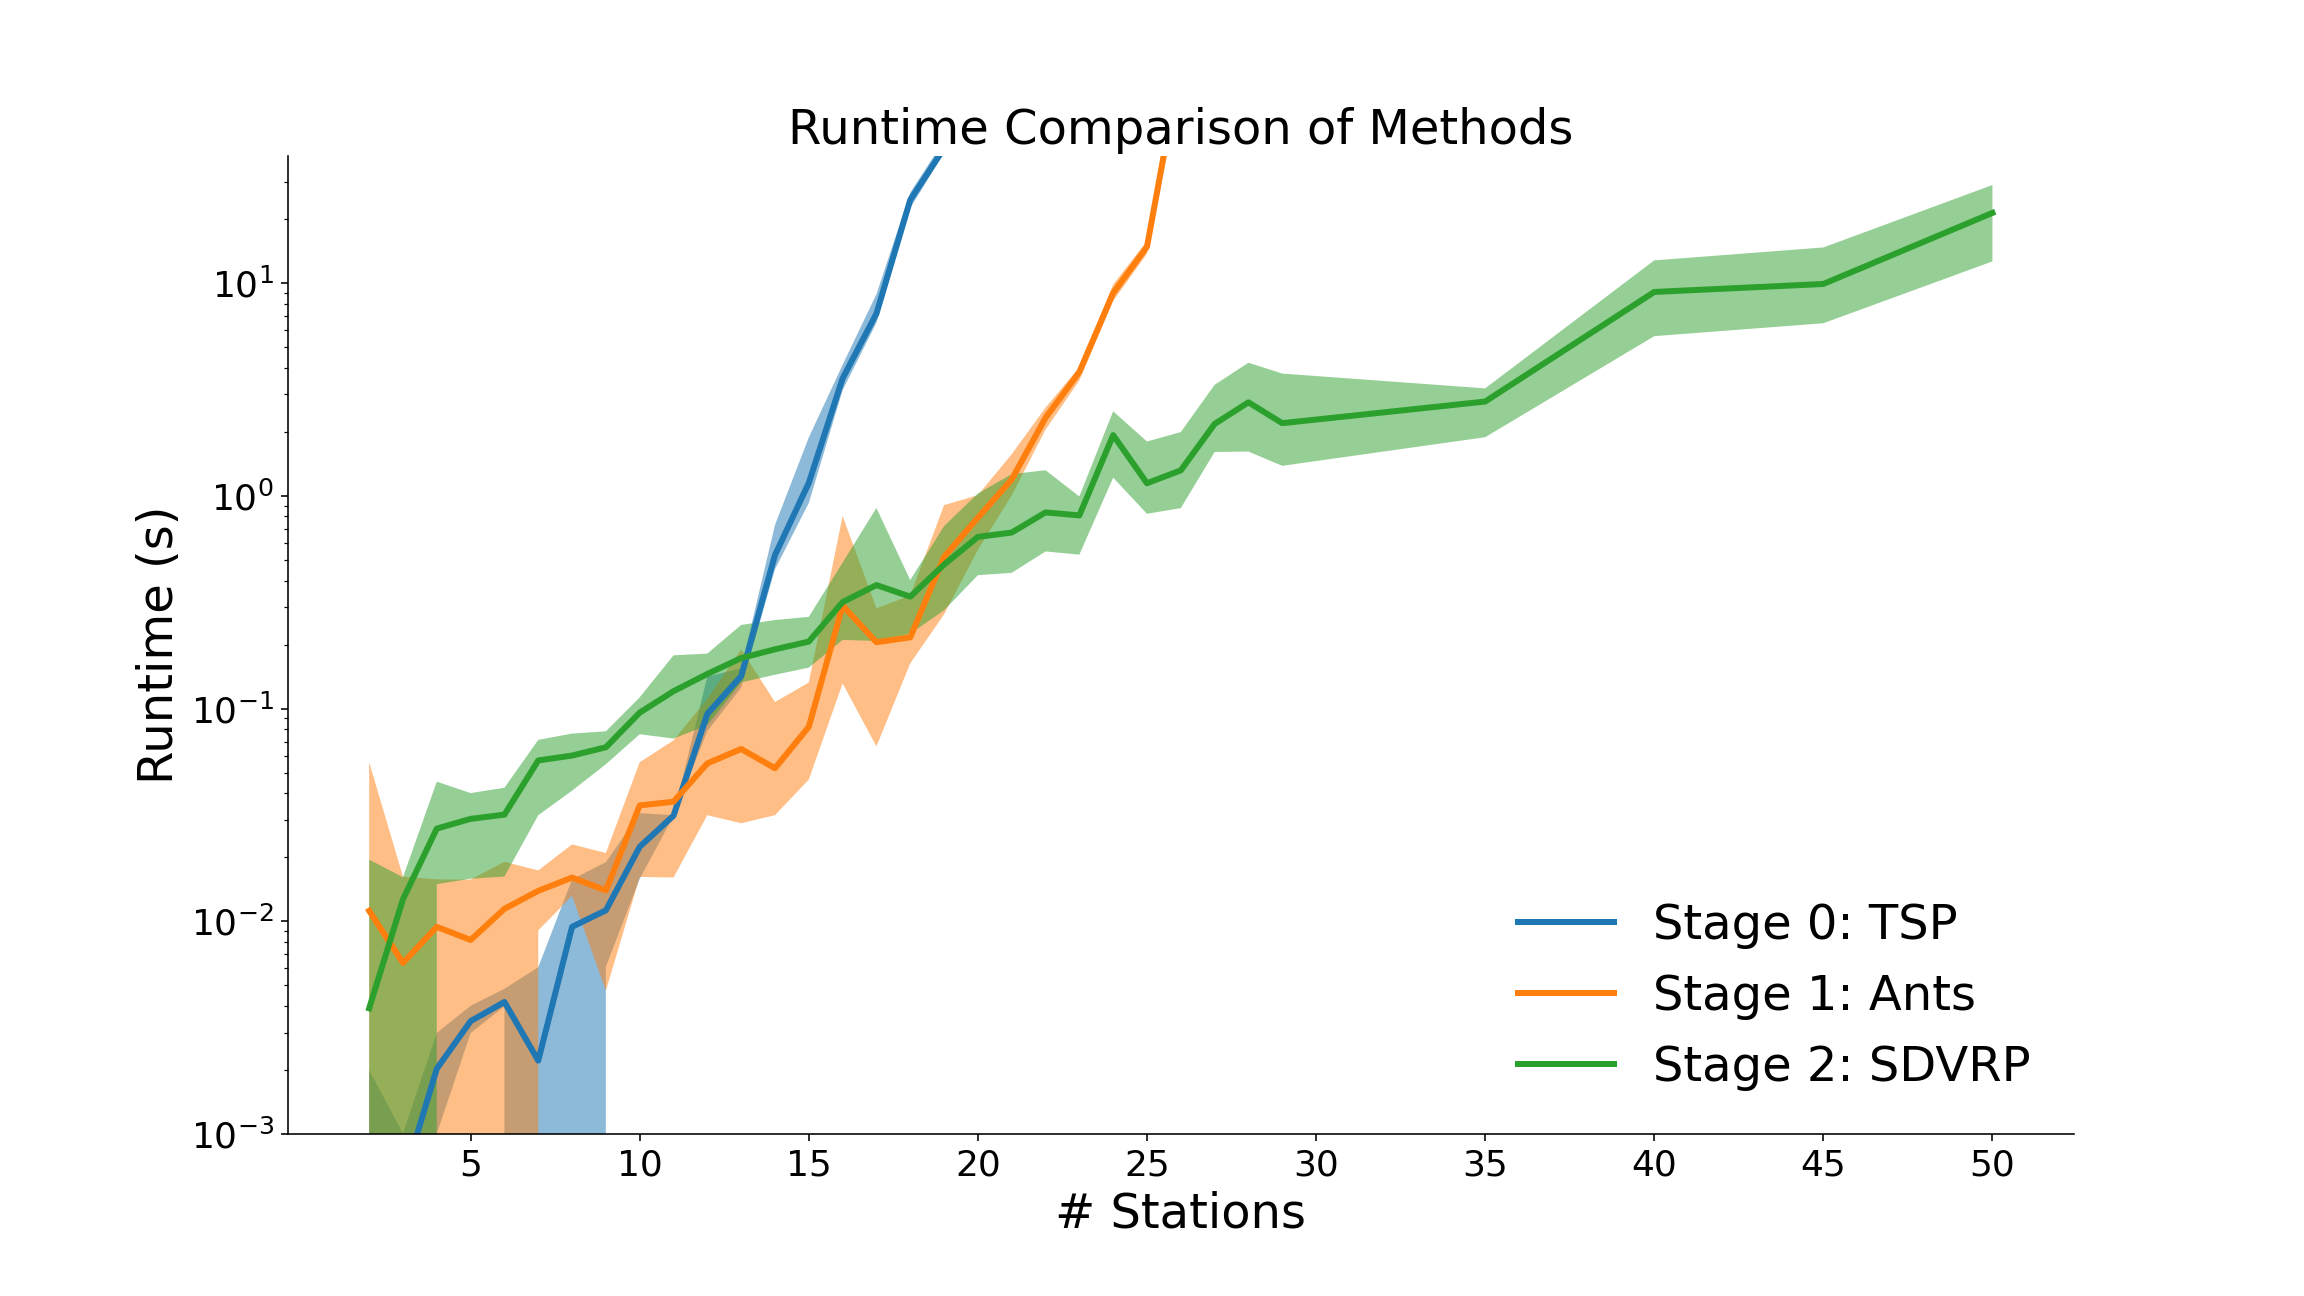

**Figure 13**: Runtime Comparison of MIP Formulations on Random Formulations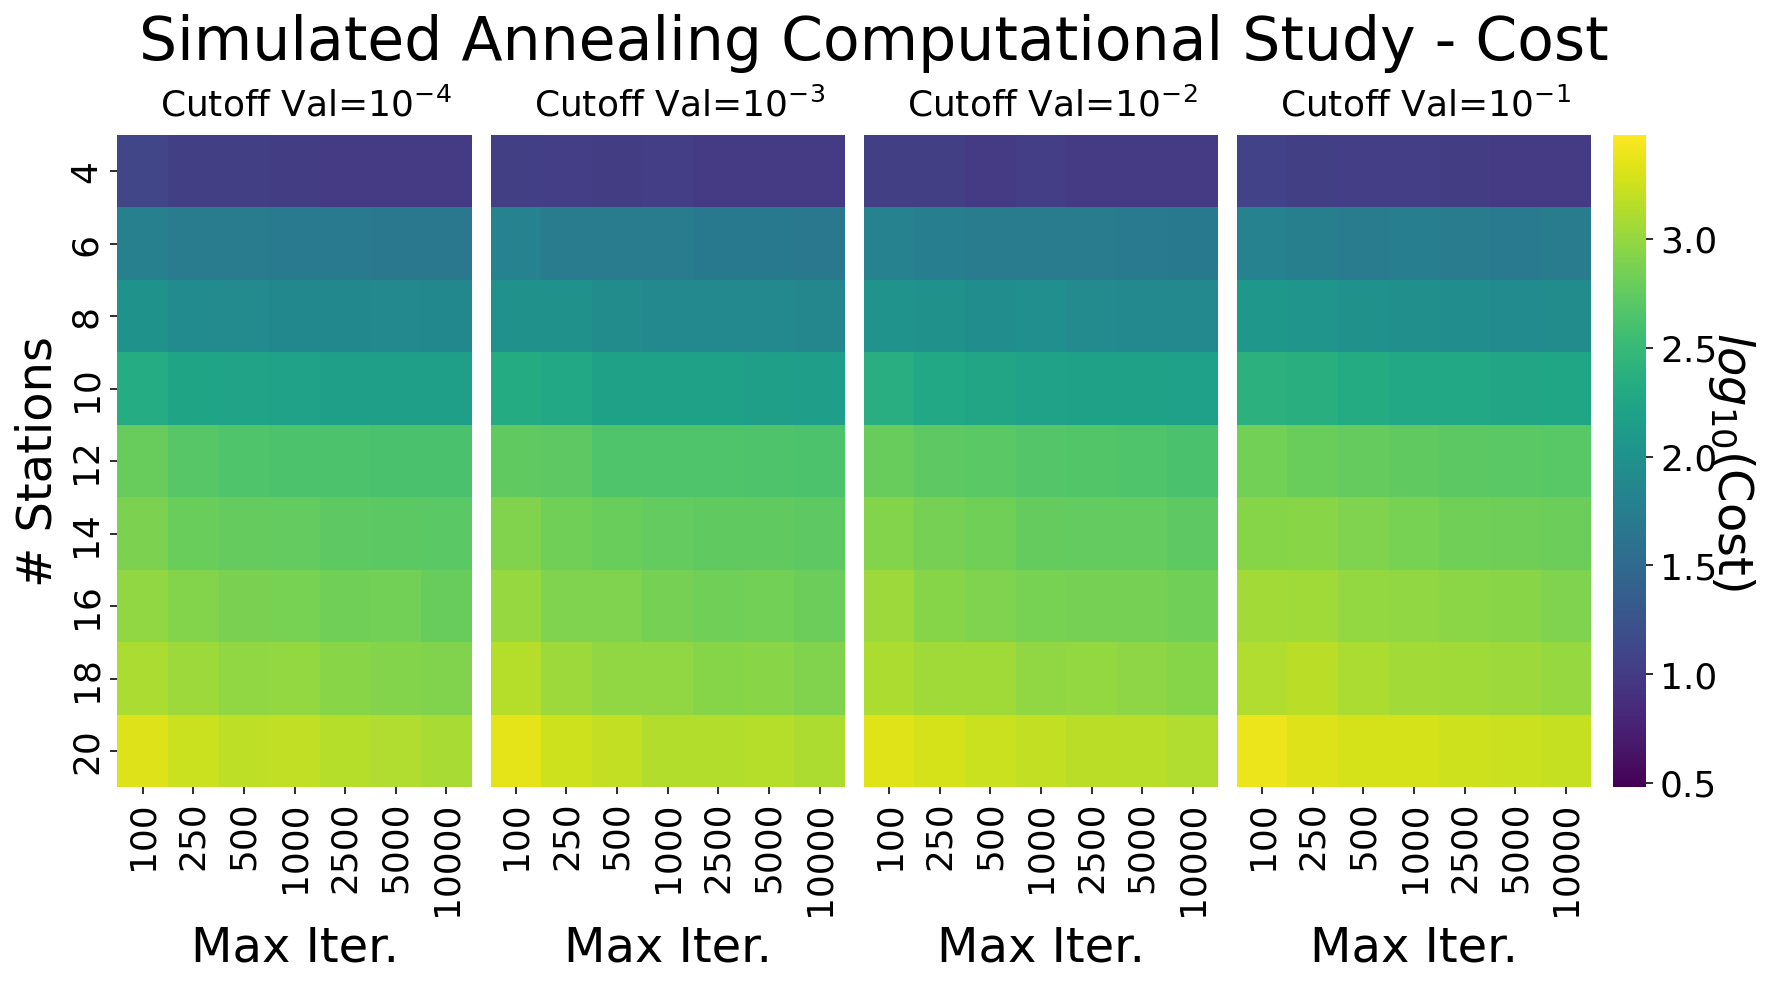

**Figure 14**: Runtime Comparison for Simulated Annealing dependent on Iterations and Station Count

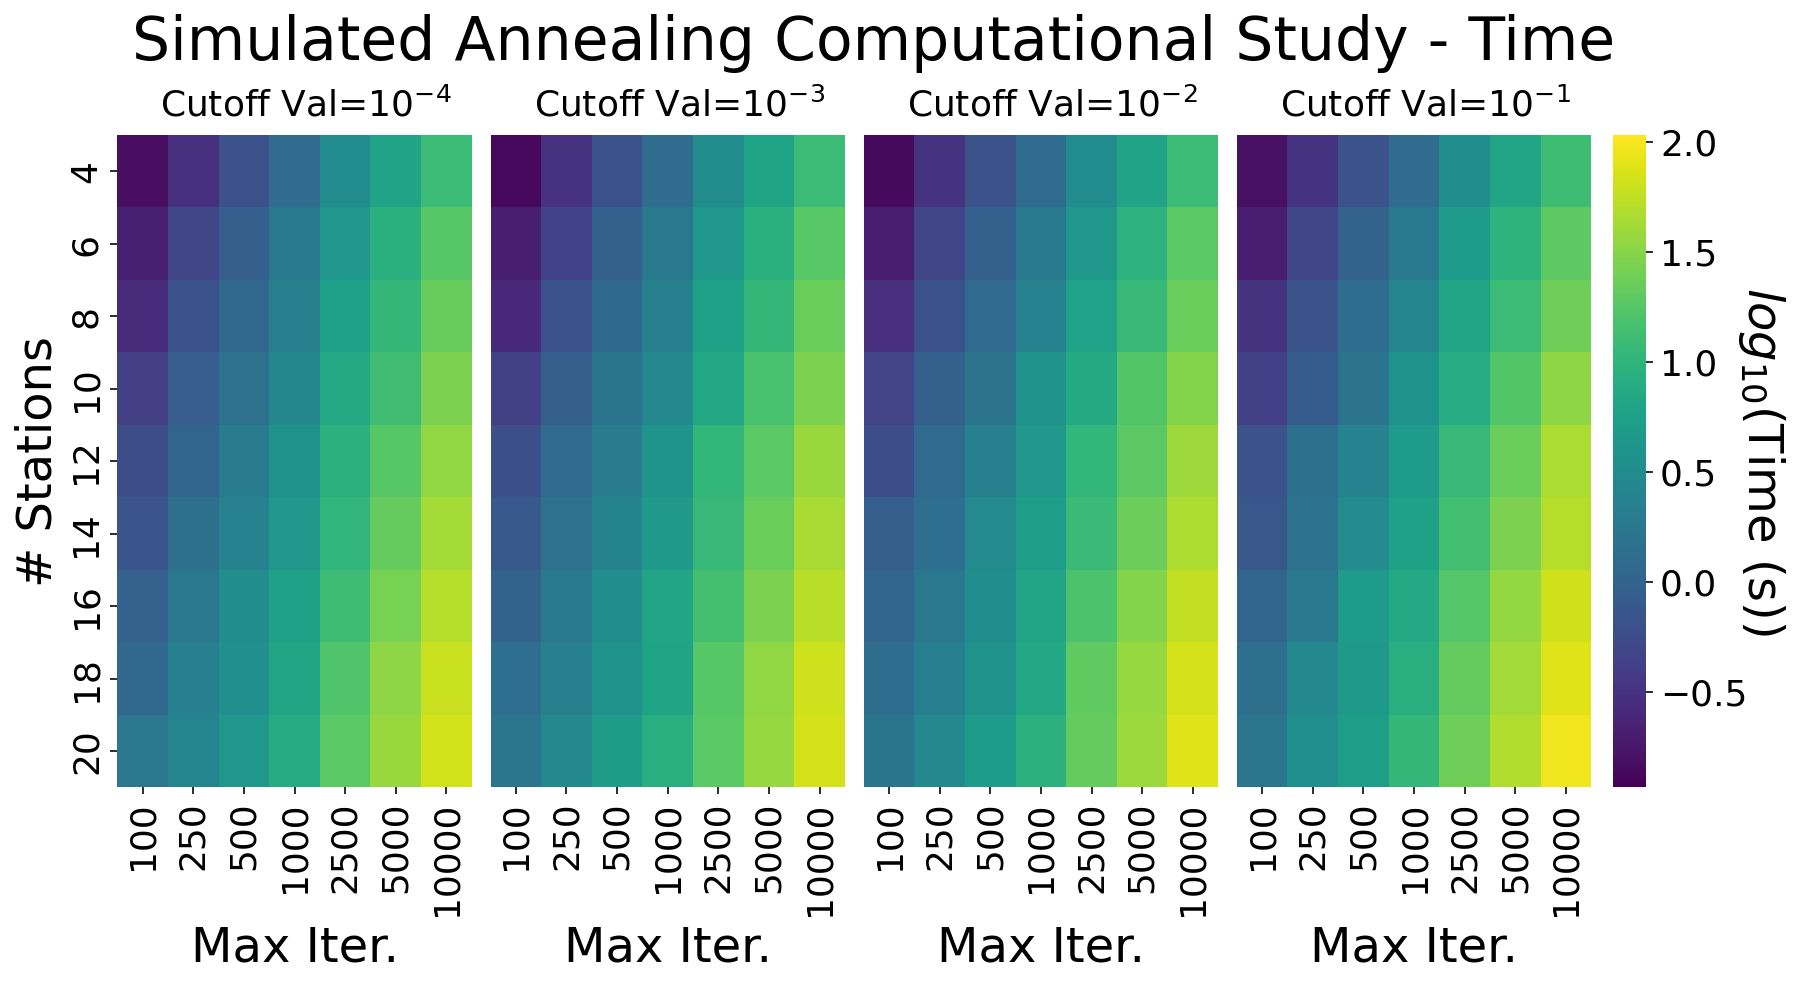

**Figure 15**: Dependence of Runtime for Simulated Annealing on Station Count

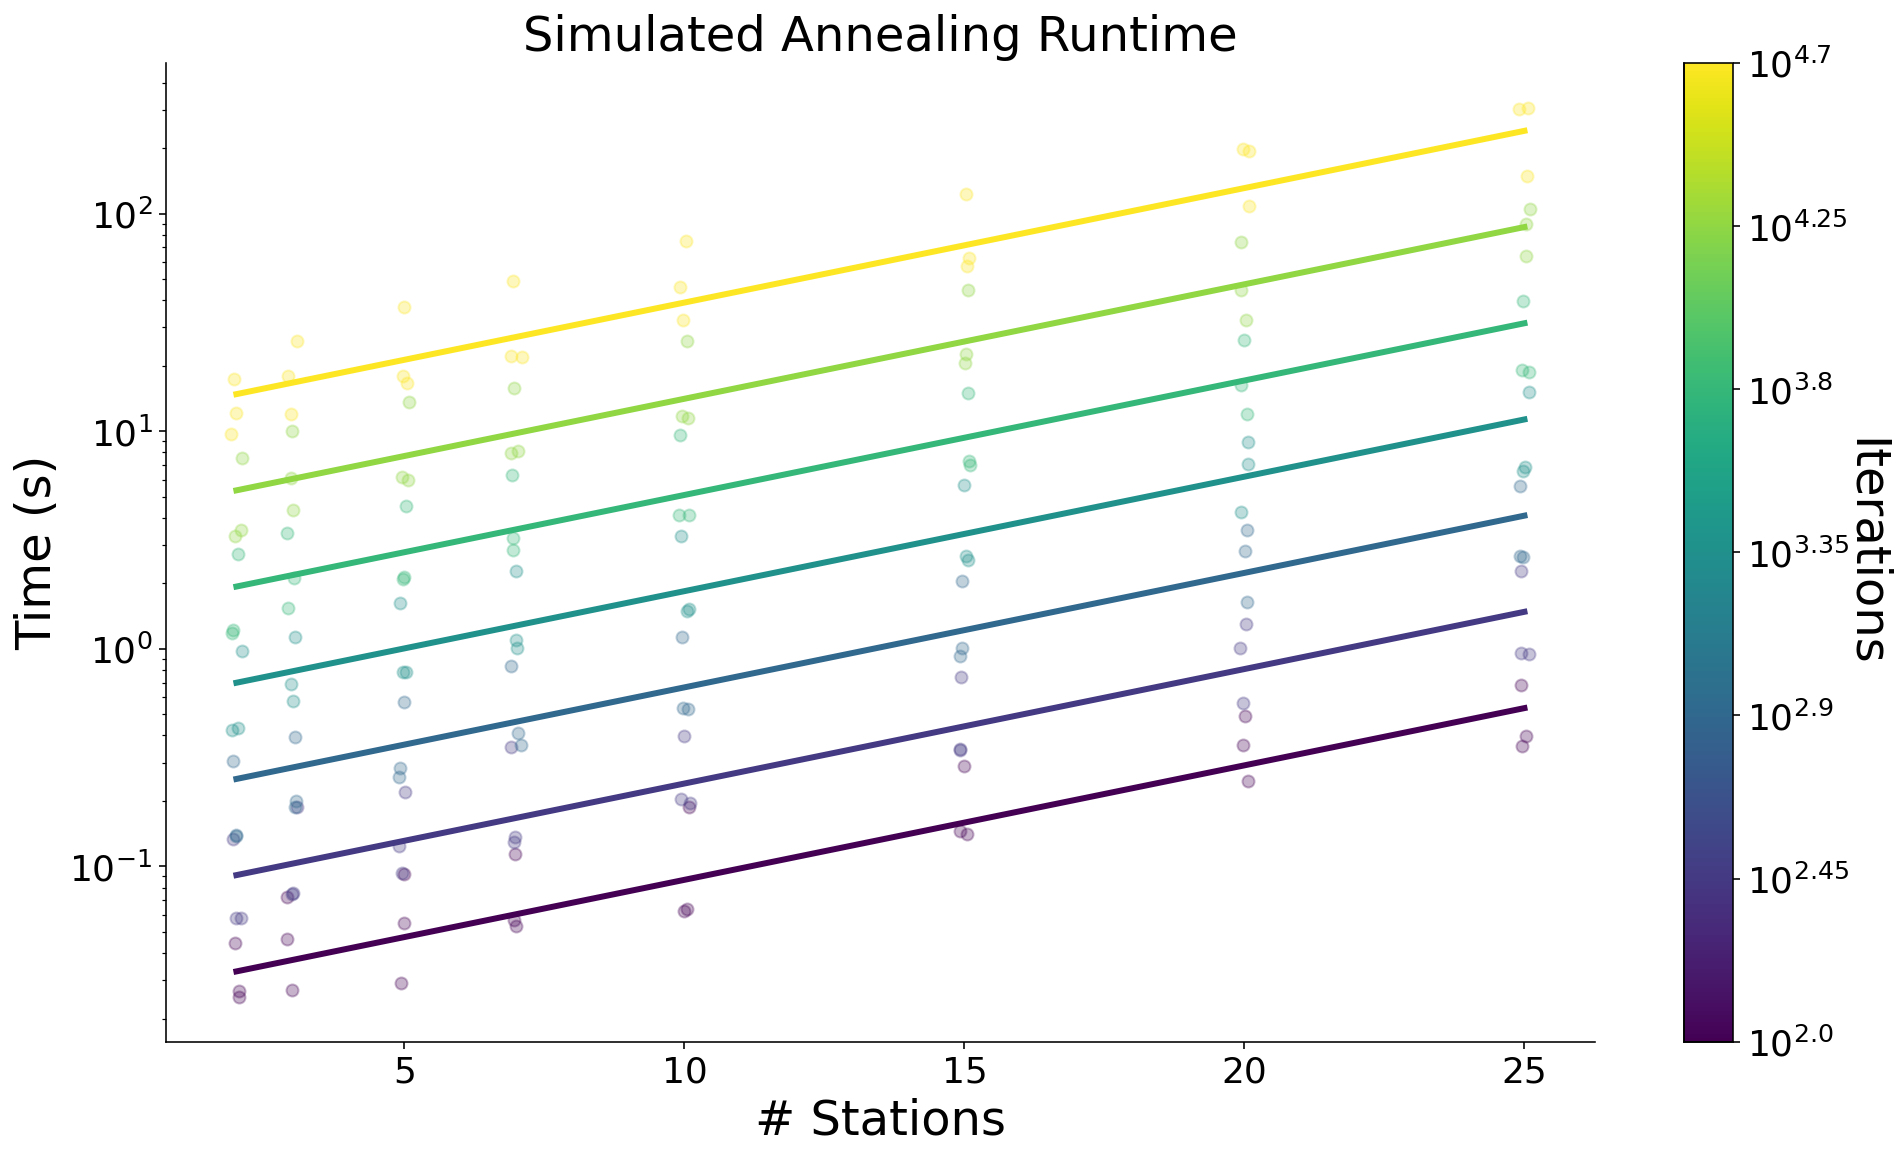

**Figure 16**: 'Straight' Test Case

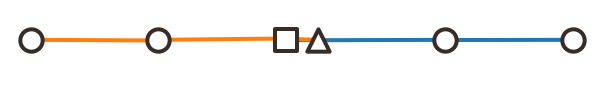

**Figure 17**: Simulated Annealing Solution Quality through Execution

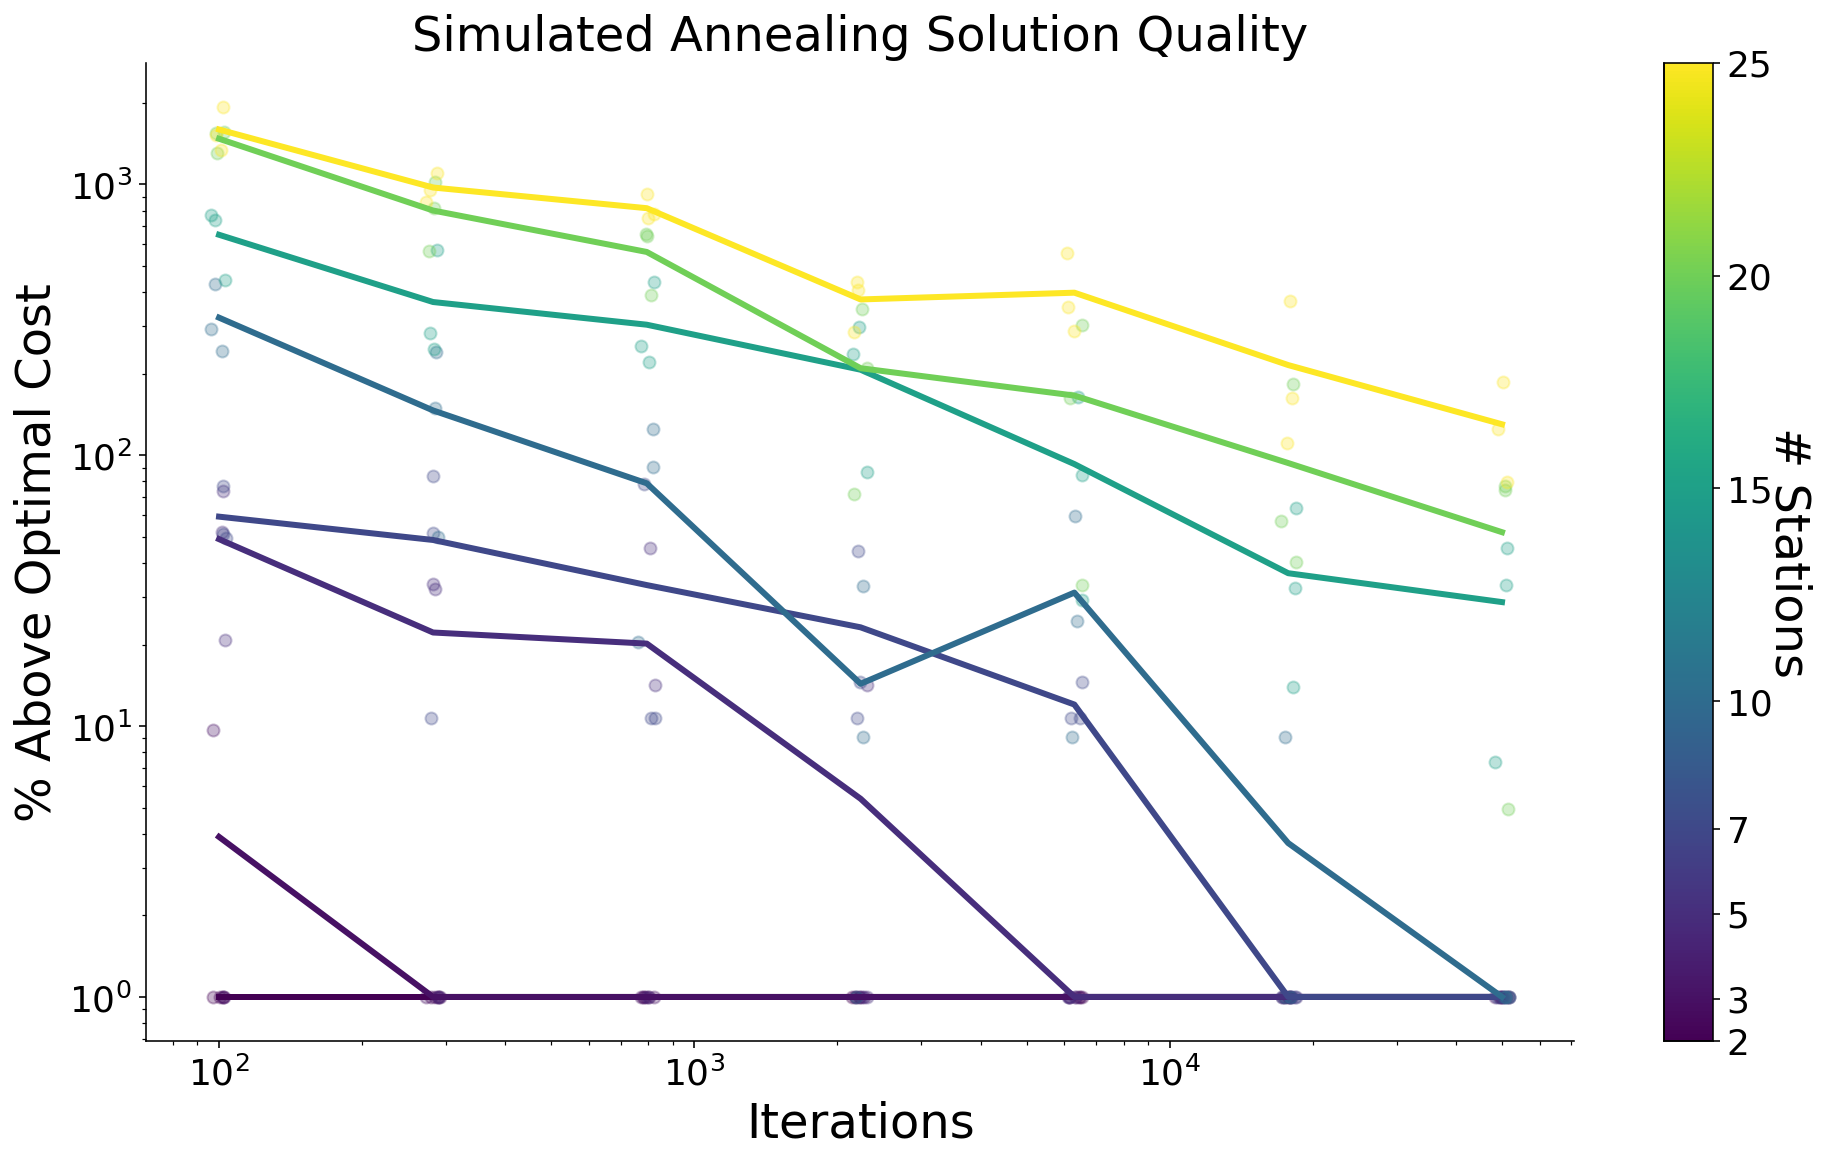

**Figure 18**: Simulated Annealing Solution Cost through Execution

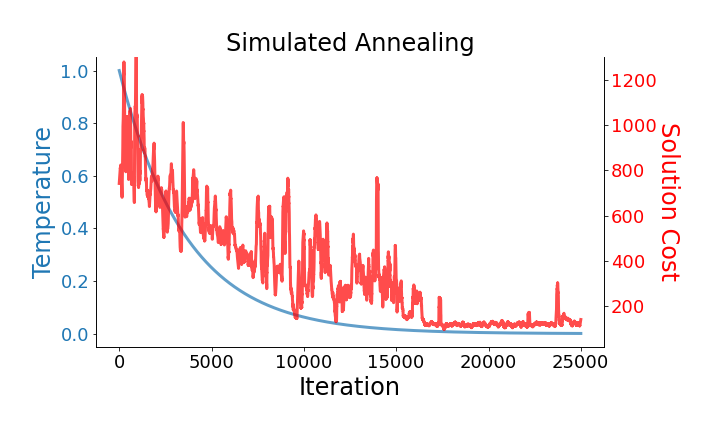

**Figure 19**: Skilled human player in-game solution for 'Barcelona'

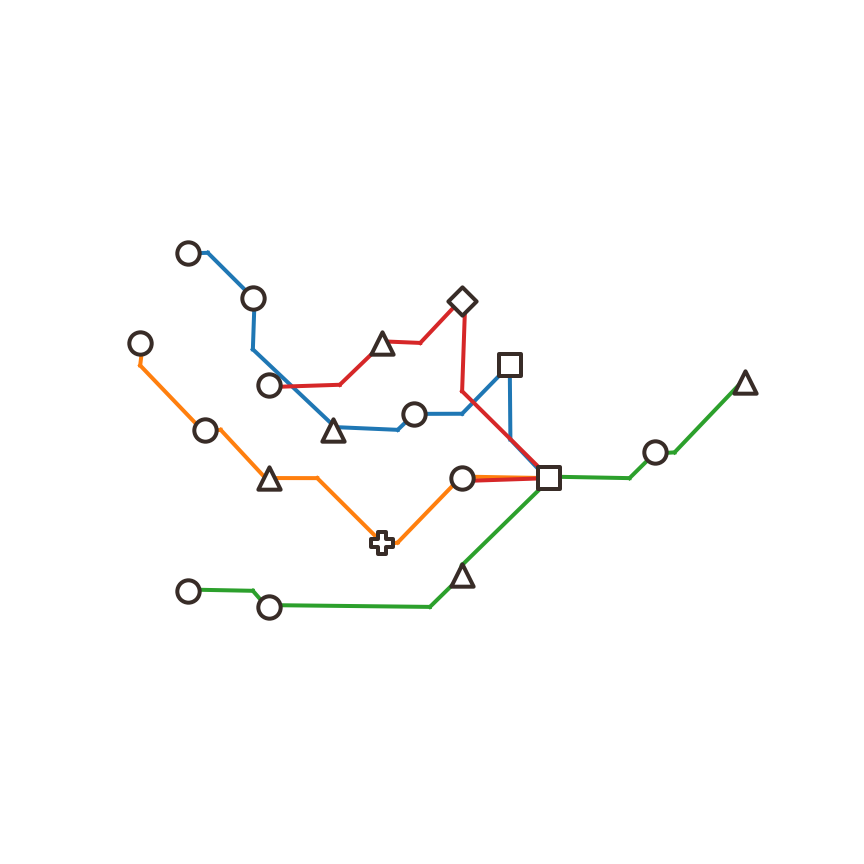

**Figure 20**: Comparison of Stage 0-3 solutions for 'Barcelona'

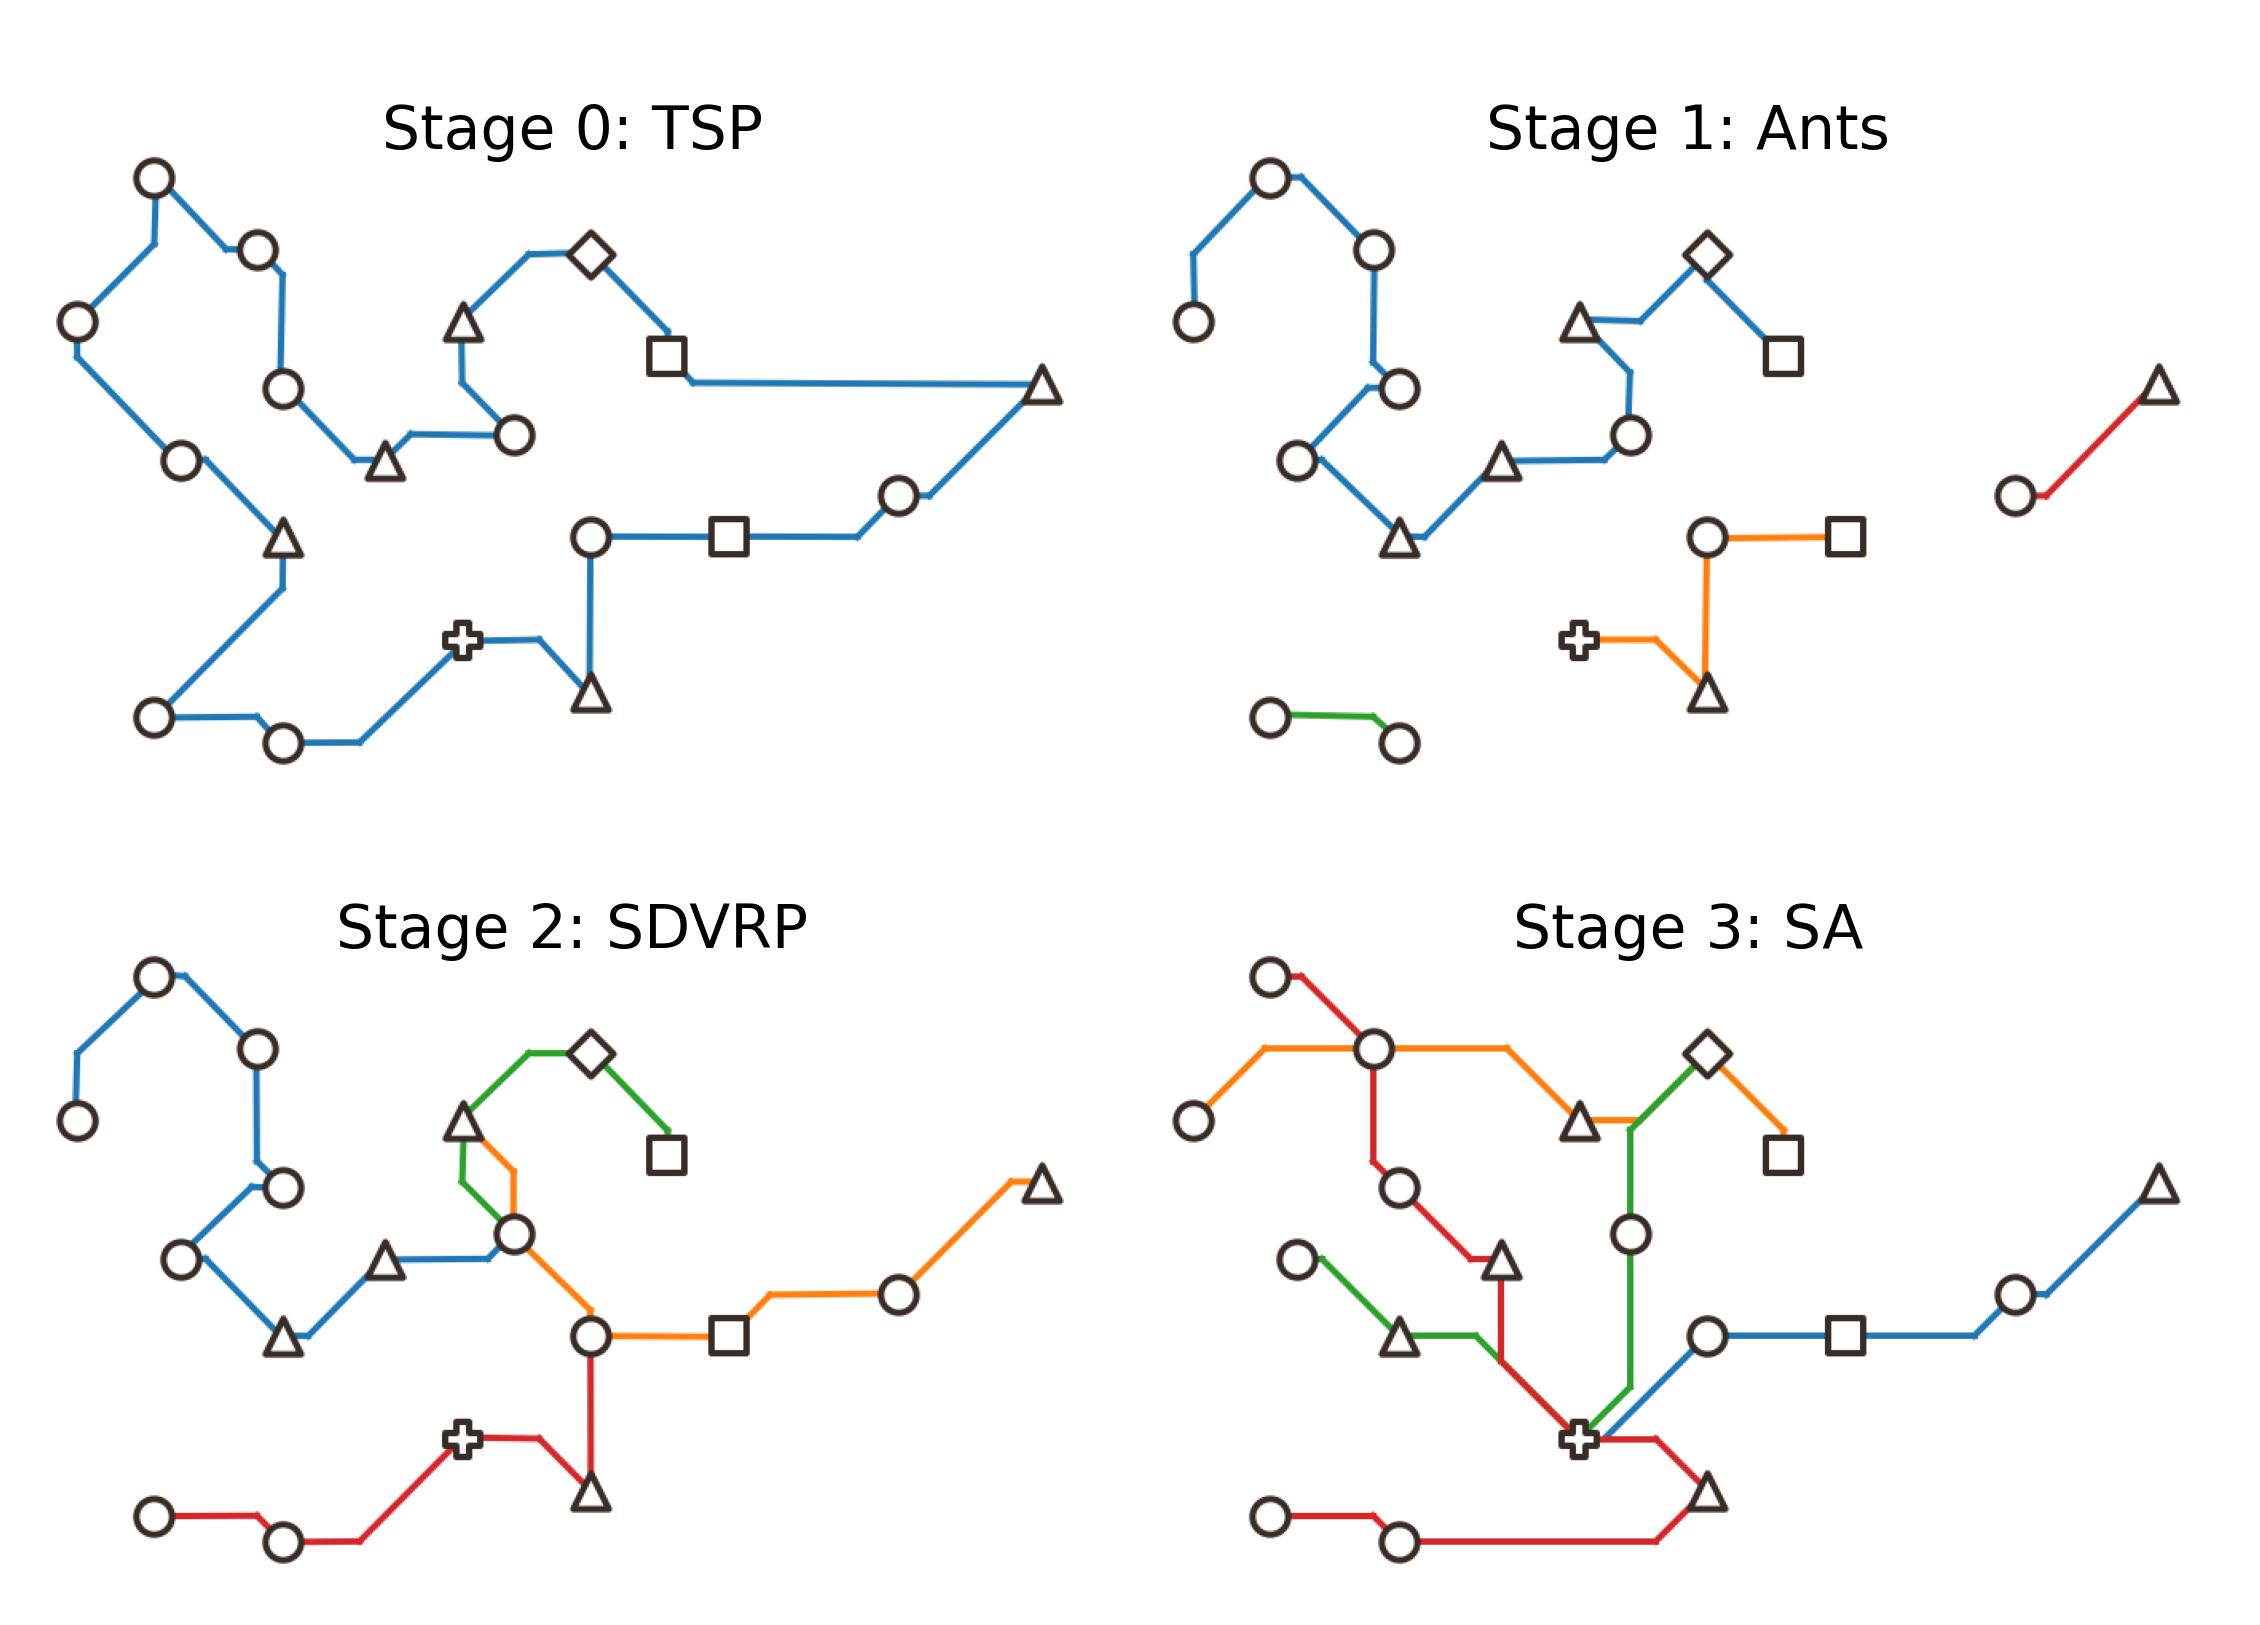

## 8. Conclusions

By following a staged approach involving progressive increases in model complexity, we were able to produce a final simulated annealing model to provide practically feasible solutions for any given Mini Metro problem. This algorithm has a workable runtime complexity for low to medium-complexity station layouts and can be run for longer periods of time if a user desires better solutions. The modelling required simplifying assumptions, in particular: ignoring the temporality and stochasticity associated with placement of future stations and passengers, and the movement of trains and passengers on a rail.

Our final model can be used practically in-game, as players of Mini Metro may pause the game to freely edit their rail layouts. This means that simulated annealing could be run by a player for hours to generate the an excellent solution at any snapshot in time desired by a player during their game, and then the player could replicate the  solution in-game before continuing play. 

Our algorithm can be extended with future work to incorporate newly added stations that appear throughout each level in a computationally-efficient manner. For example, after SA has generated a solution for $N$ stations, the $(N+1)^\text{th}$ station could be randomly connected to this network and used as an initial solution for simulated annealing to start from. This saves repeated computation and can result in faster, higher quality solutions as the game progresses.

Other future directions for our work include but are not limited to:

- Improving the SDVRP flow formulation to produce superior solutions
- Use of solver or search optimisations to speed up Stage 2 SDVRP solving
- Exploration of models such as Generalised TSP for handling heterogeneous nodes / stations
- Incorporating information on station and/or passenger kind frequency into the cost function used in SA for improved solutions.

## References

Claudia Archetti and Maria Grazia Speranza. “The Split Delivery Vehicle Routing Problem: A Survey”. In: The Vehicle Routing Problem: Latest Advances and New Challenges. Ed. by Bruce Golden, S. Raghavan, and Edward Wasil. Boston, MA: Springer US, 2008, pp. 103–122. isbn: 978-0-387-77778-8. doi: 10.1007/978-0-387-77778-8_5. url: https://doi.org/10.1007/978-0-387-77778-8_5.

Tolga Bektas. “The multiple traveling salesman problem: an overview of formulations and solution procedures”. In: Omega 34.3 (2006), pp. 209–219. issn: 0305-0483. doi: https://doi.org/10.1016/j.omega.2004.10.004. url: https://www.sciencedirect.com/science/article/pii/S0305048304001550.

Bertsimas, D., & Tsitsiklis, J. (1993). Simulated annealing. Statistical science, 8(1), 10-15.

Dinosaur Polo Club. "Mini Metro". (2014) https://dinopoloclub.com/games/mini-metro/.

Drawing Dead. “Mini Metro - This Perfect Dream Achievement (Barcelona).” Drawing Dead. January 8, 2020. Video Game instructional video, 12:27. https://youtu.be/2UElC_YZ0Eo.

Moshe Dror, Gilbert Laporte, and Pierre Trudeau. “Vehicle routing with split deliveries”. In: Discrete Applied Mathematics 50.3 (1994), pp. 239–254. issn: 0166-218X. doi: https://doi.org/10.1016/0166-218X(92)00172-I. url: https://www.sciencedirect.com/science/article/pii/0166218X9200172I.

Bezalel Gavish and Stephen C. Graves. “The Travelling Salesman Problem and Related Problems”. In: Operations Research Centre, Massachusetts Institute of Technology, 1978.

Soheil Ghafurian and Nikbakhsh Javadian. “An ant colony algorithm for solving fixed destination multi-depot multiple traveling salesmen problems”. In: Applied Soft Computing 11.1 (2011), pp. 1256–1262. issn: 1568-4946. doi: https://doi.org/10.1016/j.asoc.2010.03. 002. url: https://www.sciencedirect.com/science/article/pii/S1568494610000682.

Jarrett Walker. "Learning from 'Mini Metro'". (2014). https://humantransit.org/2014/12/learning-how-transit-works-from-mini-metro.html
